# An Analysis of Wind Speeds in the North Sea

---

### Data

We will be working with [data](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/) collected by [DWD](https://dwd.de) on Helgoland in a 10-minute intervall from 1996 to 2022. For loading the data, we have to manually collect the from a http server.


### Imports and Usage

You can simply use the `environment.yml` file to create a new conda environment with all the needed packages by running `conda env create -f environment.yml`. The only relevant parameter you may want to change is `RELOAD`. If set to `True`, all the needed data will be downloaded and saved in the `data/` folder.

## Data Loading

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime as dt
import matplotlib.dates as mdt
from tueplots import bundles
import tueplots as tp
import tueplots.constants.color as tpc
import math

import scipy.optimize as opt
import scipy.integrate
import scipy


from sklearn.gaussian_process import GaussianProcessRegressor as GP
import sklearn.gaussian_process.kernels as GPK
import joypy as jpy
import os

import sys
sys.path.append("../util/")
from dataloader import Loader
from weibull import Weibull
from dates import days_to_date
from misc import ridgeline_plot

def full_fig(nrows=1, ncols=1):
    plt.rcParams.update(bundles.icml2022(column="full"))
def half_fig(nrows=1, ncols=1):
    plt.rcParams.update(bundles.icml2022(column="half"))
def set_dpi(dpi):
    plt.rcParams.update({"figure.dpi": dpi})

tpc.rgb.
    
plt.rcParams.update(bundles.icml2022(column="full"))
plt.rcParams.update({"figure.dpi": 300})
# plt.rcParams["font.family"] = "DejaVu Sans"

# set true to download the data and unzip into the current directory
RELOAD = False
ZIP_NAME = "data.zip"
DATA_FOLDER = "../data"
FIGURE_FOLDER = "../paper/fig"

DATA_BASE_URL = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/"
METRICS = ["wind", "air_temperature", "precipitation", "solar"]
METRIC_URLS = [DATA_BASE_URL + postfix + "/historical/" for postfix in METRICS]
print(METRIC_URLS)

['https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/wind/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/solar/historical/']


In [2]:
loader = Loader(METRICS, DATA_FOLDER)
metric_files = loader.download_all_metrics(reset=False)

for kind in METRICS:
    print(f"Files containing {kind} data:\n\t{metric_files[kind]}")

kind_df, df = loader.as_dataframe

Files containing wind data:
	['/Users/david/Uni/WS2324/Data-Literacy/DataLiteracyProject/data/wind/produkt_zehn_min_ff_19961220_19991231_02115.txt', '/Users/david/Uni/WS2324/Data-Literacy/DataLiteracyProject/data/wind/produkt_zehn_min_ff_20000101_20091231_02115.txt', '/Users/david/Uni/WS2324/Data-Literacy/DataLiteracyProject/data/wind/produkt_zehn_min_ff_20100101_20191231_02115.txt', '/Users/david/Uni/WS2324/Data-Literacy/DataLiteracyProject/data/wind/produkt_zehn_min_ff_20200101_20221231_02115.txt']
Files containing air_temperature data:
	['/Users/david/Uni/WS2324/Data-Literacy/DataLiteracyProject/data/air_temperature/produkt_zehn_min_tu_19961219_19991231_02115.txt', '/Users/david/Uni/WS2324/Data-Literacy/DataLiteracyProject/data/air_temperature/produkt_zehn_min_tu_20000101_20091231_02115.txt', '/Users/david/Uni/WS2324/Data-Literacy/DataLiteracyProject/data/air_temperature/produkt_zehn_min_tu_20100101_20191231_02115.txt', '/Users/david/Uni/WS2324/Data-Literacy/DataLiteracyProject/data

In [3]:
# print(df.dtypes)
for metric, metric_df in kind_df.items():
    print(metric_df.dtypes)

STATIONS_ID             int64
MESS_DATUM     datetime64[ns]
  QN_wind               int64
FF_10_wind            float64
DD_10_wind            float64
eor_wind               object
dtype: object
STATIONS_ID                        int64
MESS_DATUM                datetime64[ns]
QN_air_temperature               float64
PP_10_air_temperature            float64
TT_10_air_temperature            float64
TM5_10_air_temperature           float64
RF_10_air_temperature            float64
TD_10_air_temperature            float64
  QN_air_temperature             float64
eor_air_temperature               object
dtype: object
STATIONS_ID                          int64
MESS_DATUM                  datetime64[ns]
QN_precipitation                   float64
RWS_DAU_10_precipitation           float64
RWS_10_precipitation               float64
RWS_IND_10_precipitation           float64
  QN_precipitation                 float64
eor_precipitation                   object
dtype: object
STATIONS_ID             

## Preprocessing

In [4]:
wind_df = kind_df["wind"]
wind_df["year"] = wind_df["MESS_DATUM"].dt.year
wind_df["month"] = wind_df["MESS_DATUM"].dt.month
wind_df["day"] = wind_df["MESS_DATUM"].dt.day

# First, get rid of NaNs

# a bit more than one year across all years is missing (~ 58000 days)
nans_by_year = wind_df[wind_df["FF_10_wind"].isna()].groupby("year")["STATIONS_ID"].count().reset_index() 
nans_by_year.columns = ["year", "#NaNs"]
print(nans_by_year)
print(f"#NaNs: {wind_df['FF_10_wind'].isna().sum()}")
wind_df.dropna(subset=["FF_10_wind"], inplace=True)
wind_df = wind_df[wind_df["FF_10_wind"] != -999]
rest_df = wind_df.groupby("year")["FF_10_wind"].count().reset_index()
rest_df.columns = ["year", "count"]
rest_df["count"] /= 24 * 6 * 365.25
print(rest_df)

    year  #NaNs
0   2000      4
1   2001     10
2   2002     30
3   2003      5
4   2007      8
5   2009    217
6   2013   1578
7   2014     62
8   2015    196
9   2016   1056
10  2017   1040
11  2018   4868
12  2019  46074
13  2020    950
14  2021   1819
15  2022    277
#NaNs: 58194
    year     count
0   1996  0.029641
1   1997  0.848334
2   1998  0.837953
3   1999  0.997433
4   2000  1.001730
5   2001  0.998403
6   2002  0.998023
7   2003  0.994714
8   2004  0.999924
9   2005  0.998992
10  2006  0.998042
11  2007  0.999163
12  2008  1.002053
13  2009  0.995190
14  2010  0.999316
15  2011  0.999316
16  2012  1.002053
17  2013  0.969313
18  2014  0.998137
19  2015  0.995589
20  2016  0.981976
21  2017  0.979542
22  2018  0.906761
23  2019  0.123317
24  2020  0.983991
25  2021  0.906229
26  2022  0.994049


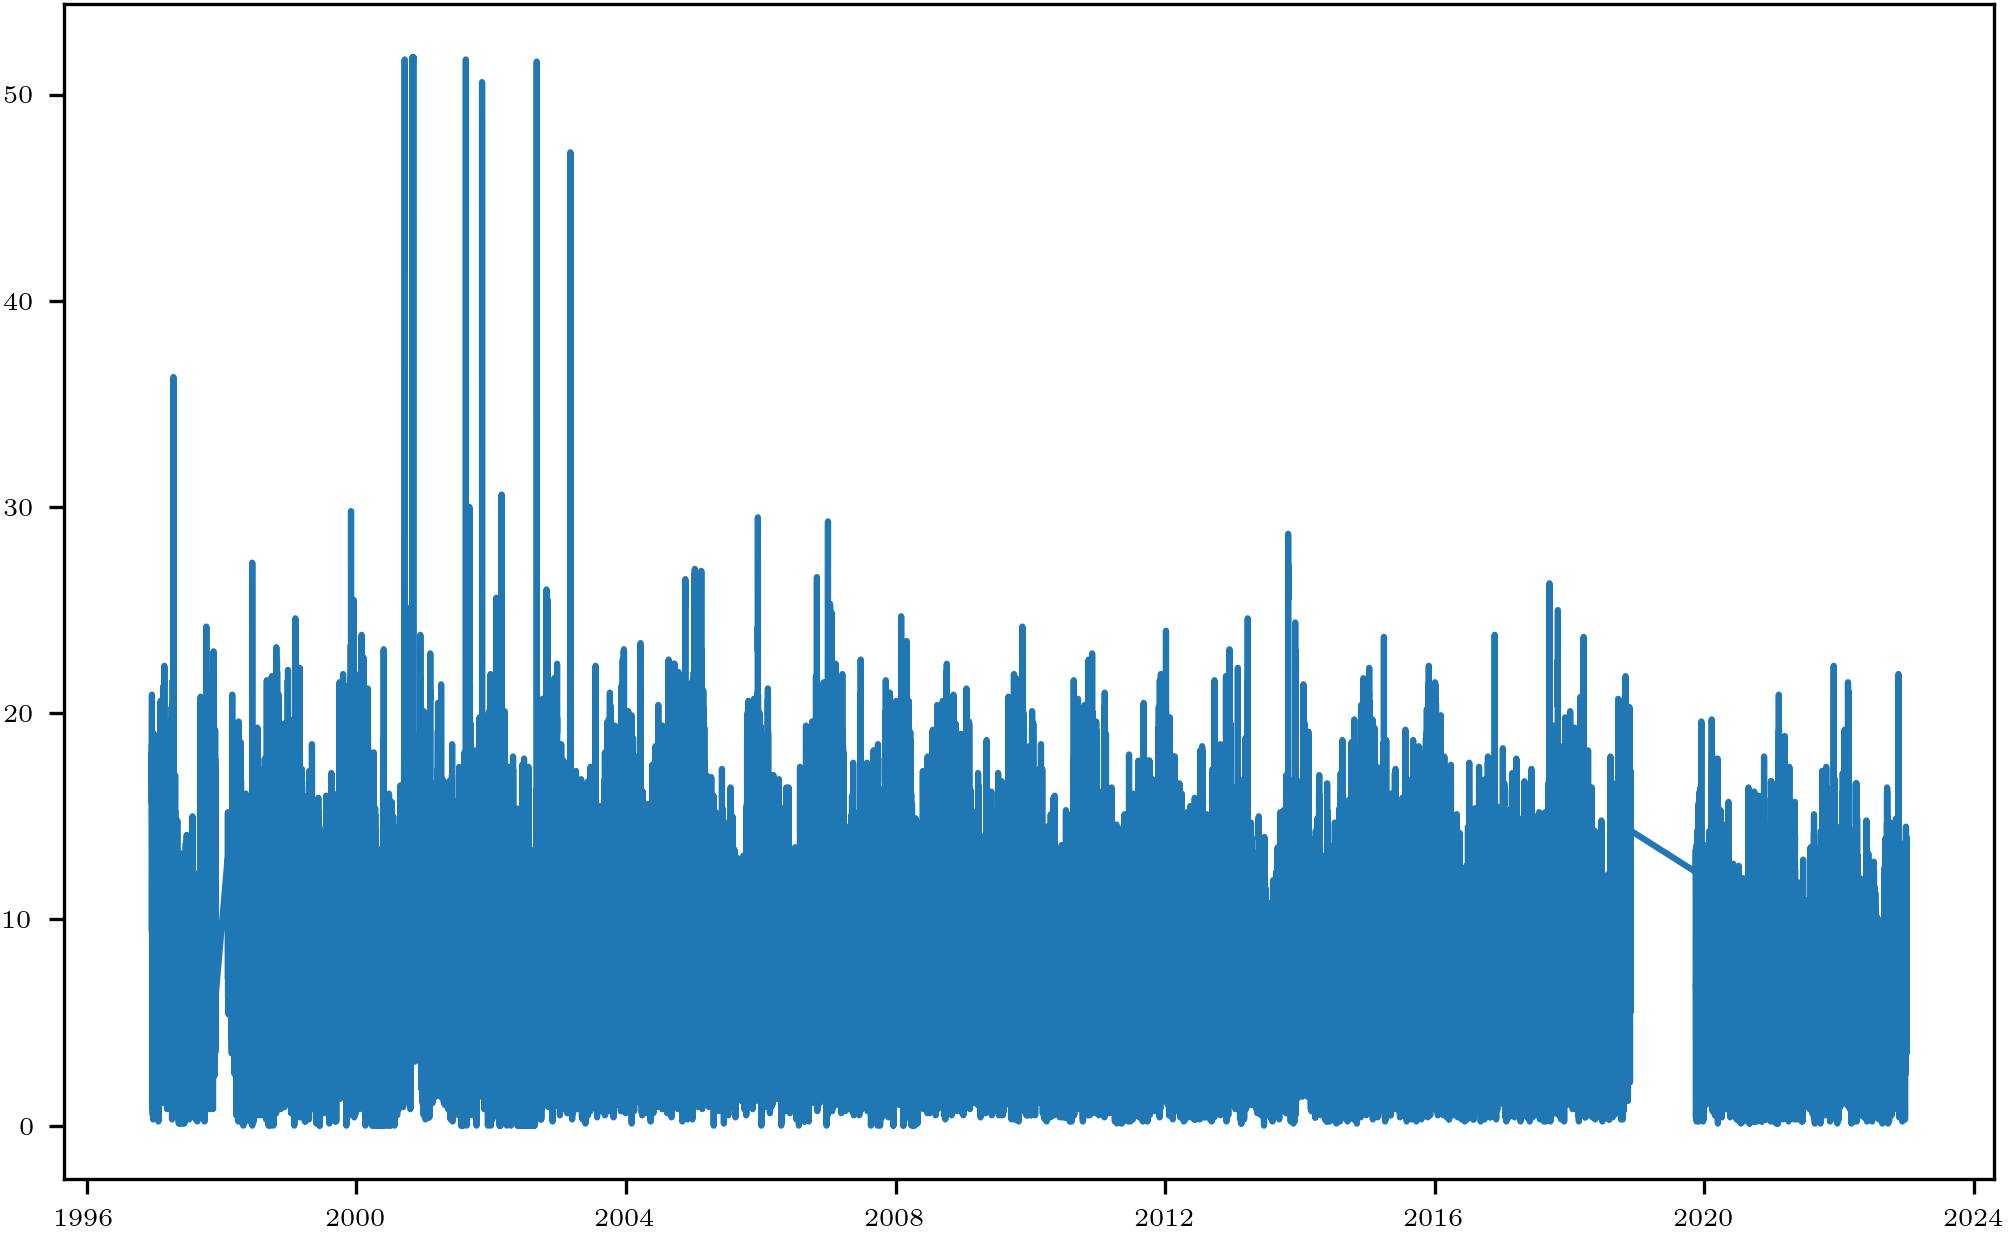

In [5]:
# there are still some outlier left
plt.plot("MESS_DATUM", "FF_10_wind", data=wind_df)
plt.show()

1158


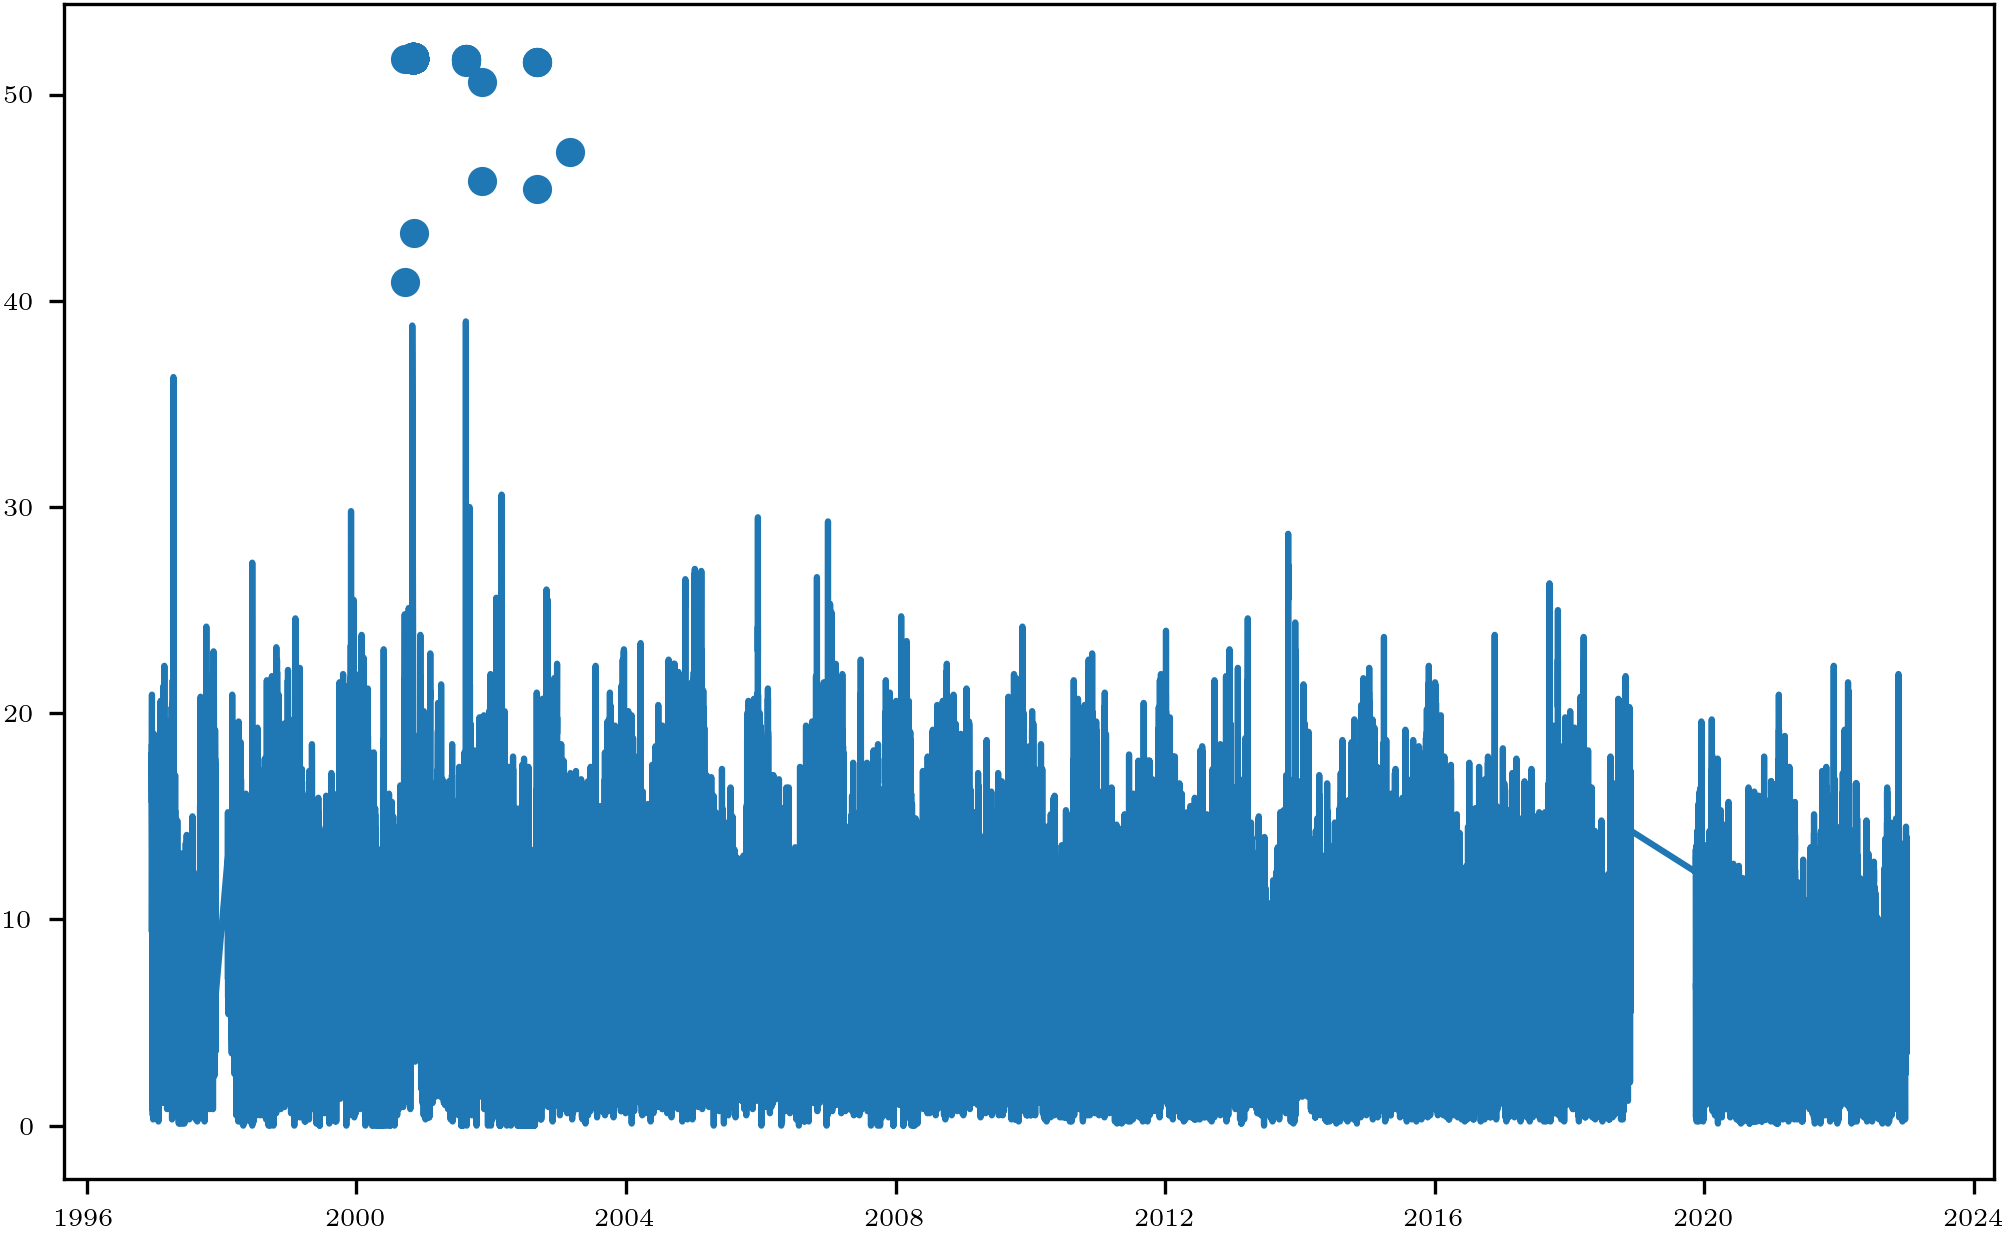

In [6]:
zscores = scipy.stats.zscore(wind_df["FF_10_wind"])
threshold = 8
plt.scatter("MESS_DATUM", "FF_10_wind", data=wind_df[zscores > threshold])
plt.plot("MESS_DATUM", "FF_10_wind", data=wind_df[zscores <= threshold])
print(wind_df[zscores > threshold].STATIONS_ID.count())
wind_df = wind_df[zscores < 8]

## Explorative Data Analysis

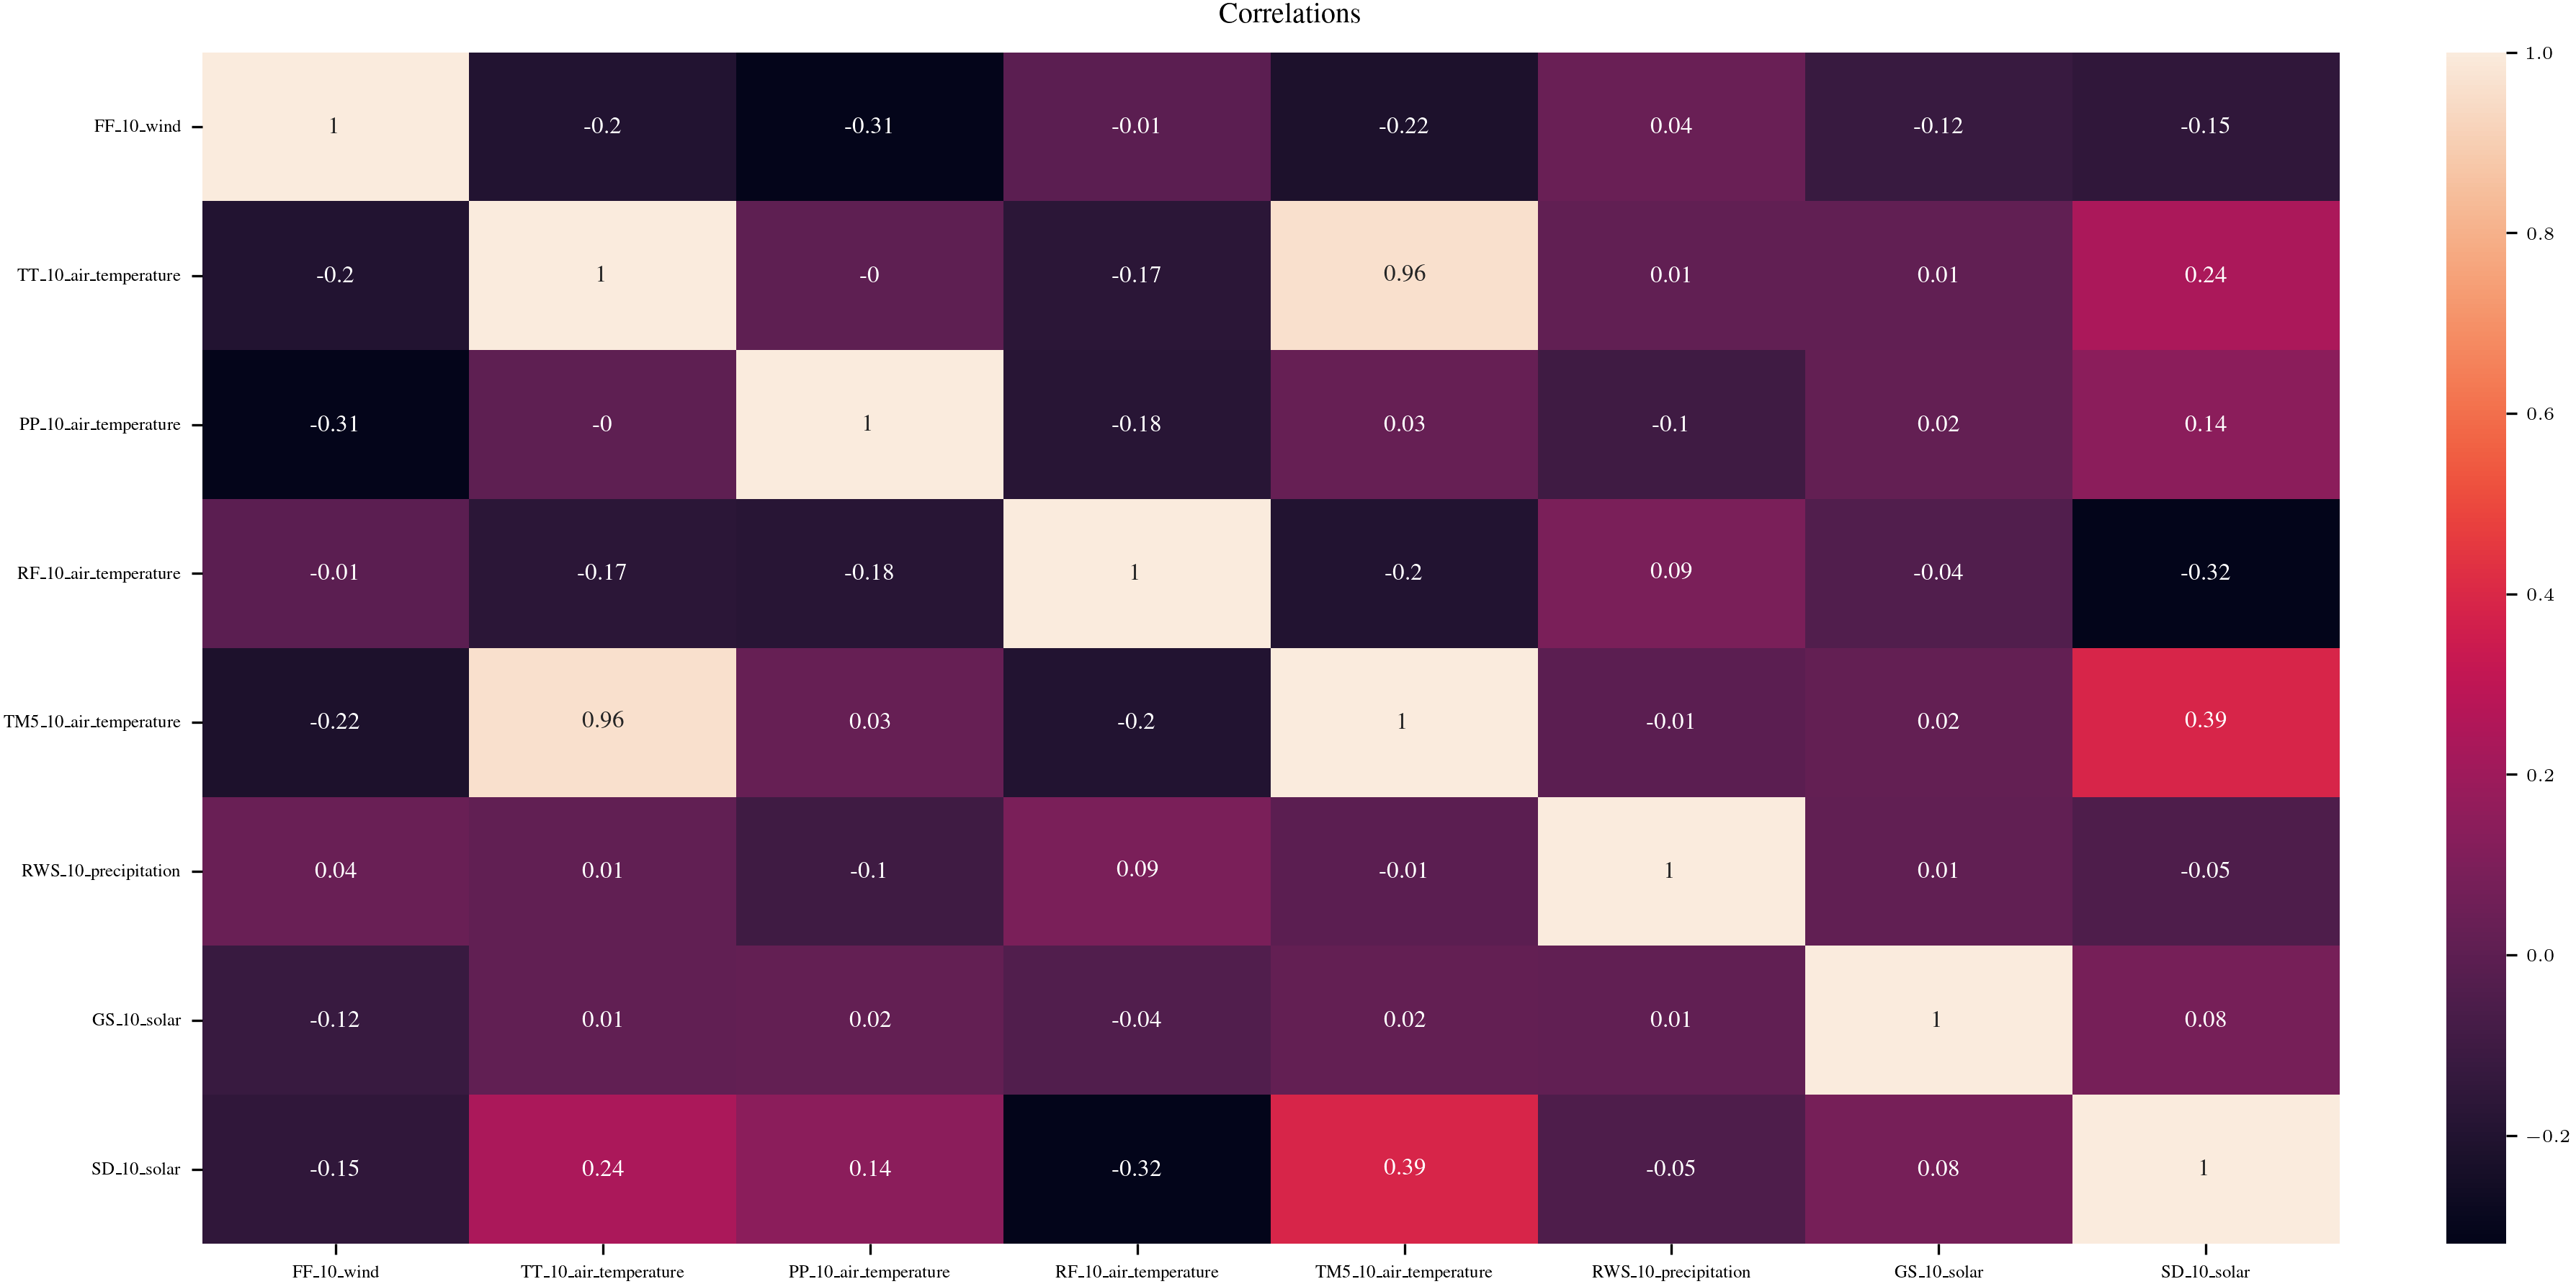

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
corr = df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
ax = sns.heatmap(corr, annot=True)
fig.suptitle("Correlations")
plt.show()

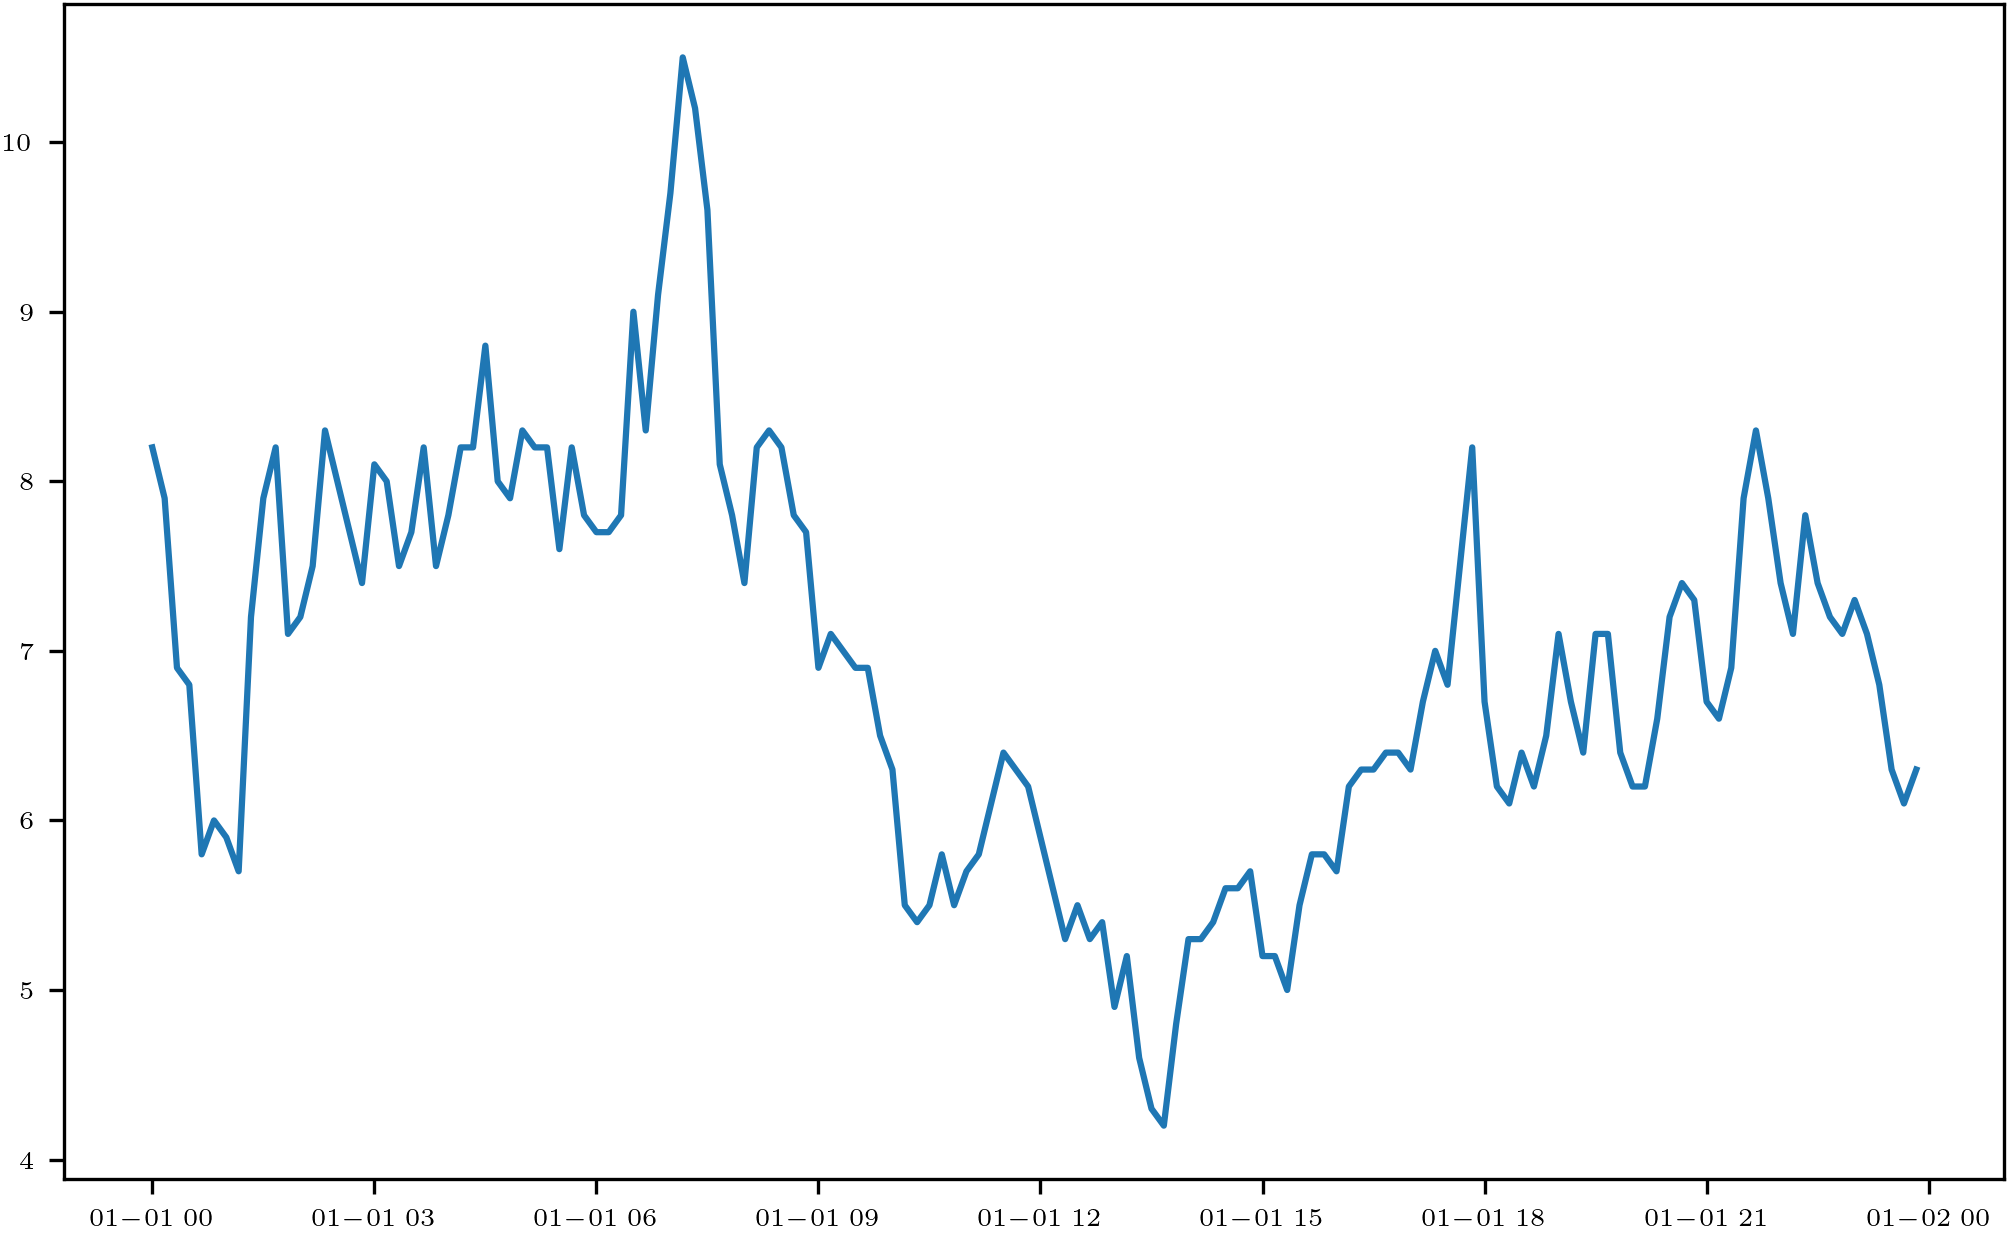

In [8]:
mask = (wind_df['MESS_DATUM'].dt.day == 1) & (wind_df['MESS_DATUM'].dt.month == 1) & (wind_df['MESS_DATUM'].dt.year == 2022)
plt.plot(wind_df[mask]["MESS_DATUM"], wind_df[mask]["FF_10_wind"])


/var/folders/zk/8tsl64_x29qcn5z6qjdgwh5h0000gn/T/ipykernel_10957/823536238.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


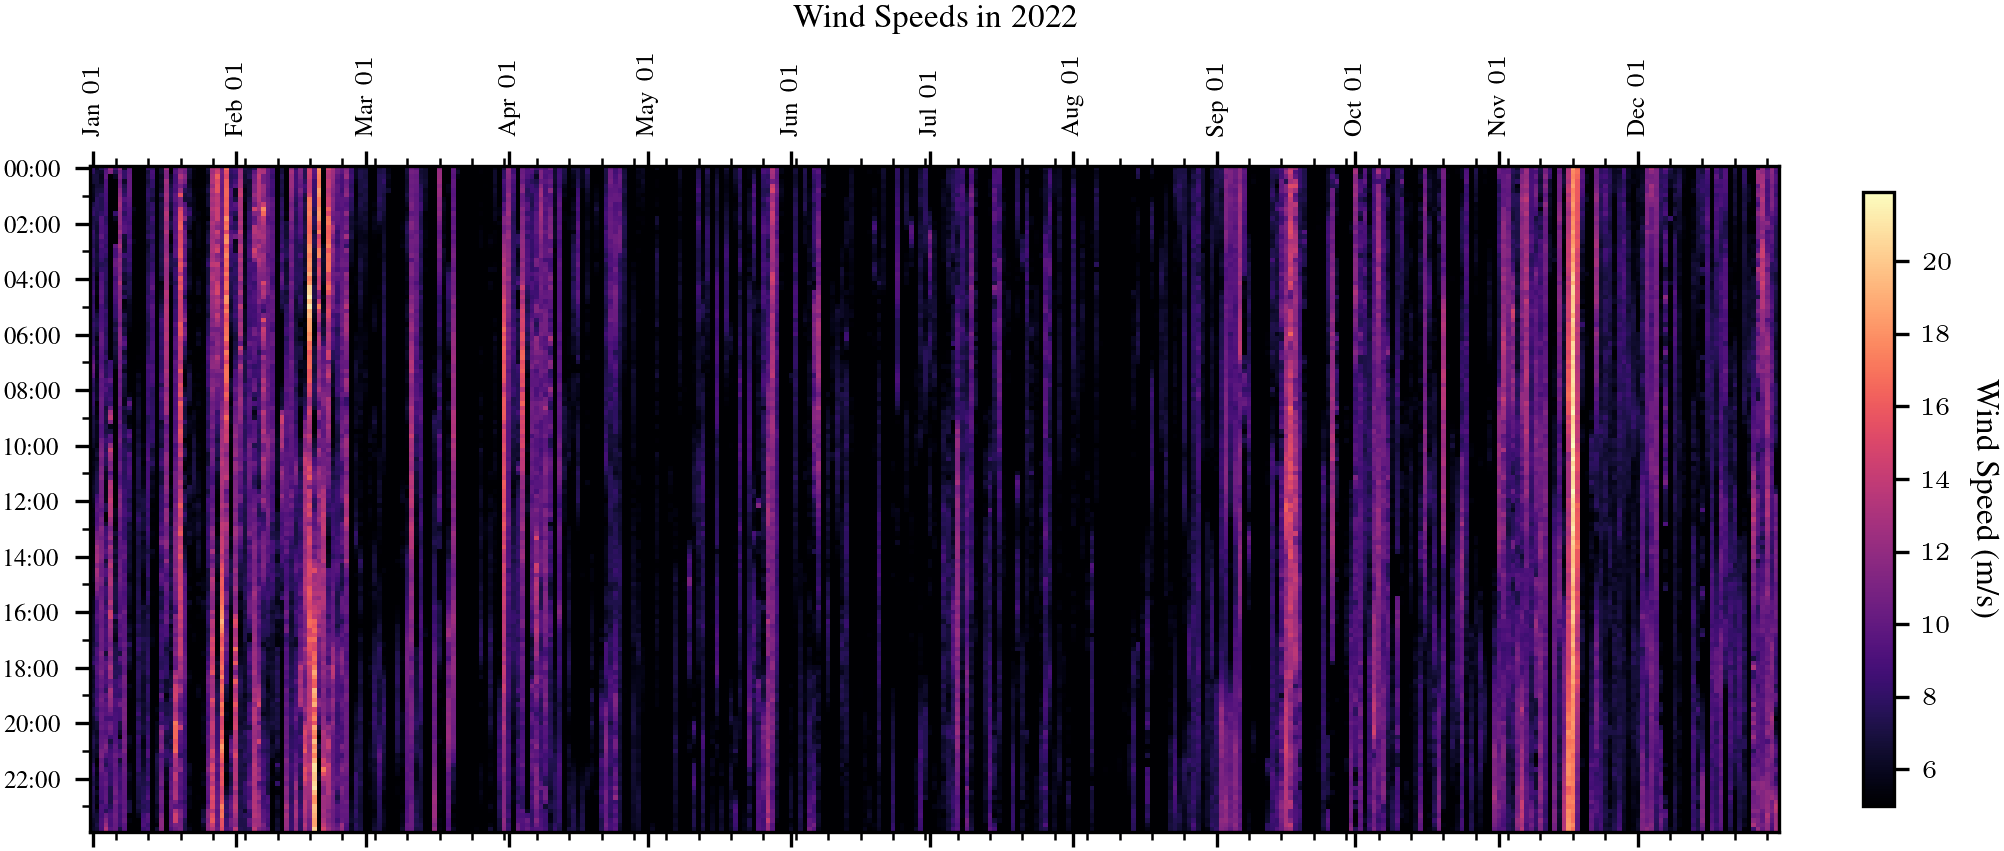

In [9]:
wind_df_2022 = wind_df[wind_df["MESS_DATUM"].dt.year == 2022].copy()
wind_df_2022["Day"] = wind_df_2022["MESS_DATUM"].dt.date
wind_df_2022["Time"] = wind_df_2022["MESS_DATUM"].dt.time

pivot_table_2022 = pd.pivot_table(
    wind_df_2022, values=("FF_10_wind"), index=["Time"], columns=["Day"], aggfunc="mean"
).fillna(0)

fig, ax = plt.subplots()
im = ax.matshow(pivot_table_2022, cmap="magma", vmin=5)

ax.set_yticks(np.arange(len(pivot_table_2022.index))[::12])
ax.set_yticks(np.arange(len(pivot_table_2022))[::6], minor=True)
ax.set_yticklabels([time.strftime("%H:%M") for time in pivot_table_2022.index[::12]])

ax.xaxis.set_major_locator(mdt.MonthLocator(interval=1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_minor_locator(
    mdt.WeekdayLocator(interval=1)
)
date_form = mdt.DateFormatter("%b %d")
ax.xaxis.set_major_formatter(date_form)
# ax.grid(which="major", axis="x", linestyle="--", linewidth="0.5", color="gray")
# ax.grid(which="major", axis="y", linestyle="--", linewidth="0.5", color="gray")

cbar = ax.figure.colorbar(im, ax=ax, shrink=0.5)
cbar.ax.set_ylabel("Wind Speed (m/s)", rotation=-90, va="bottom")

ax.set_title("Wind Speeds in 2022")
plt.show()

Text(0.5, 0.98, 'Wind Speeds 2015-2022')

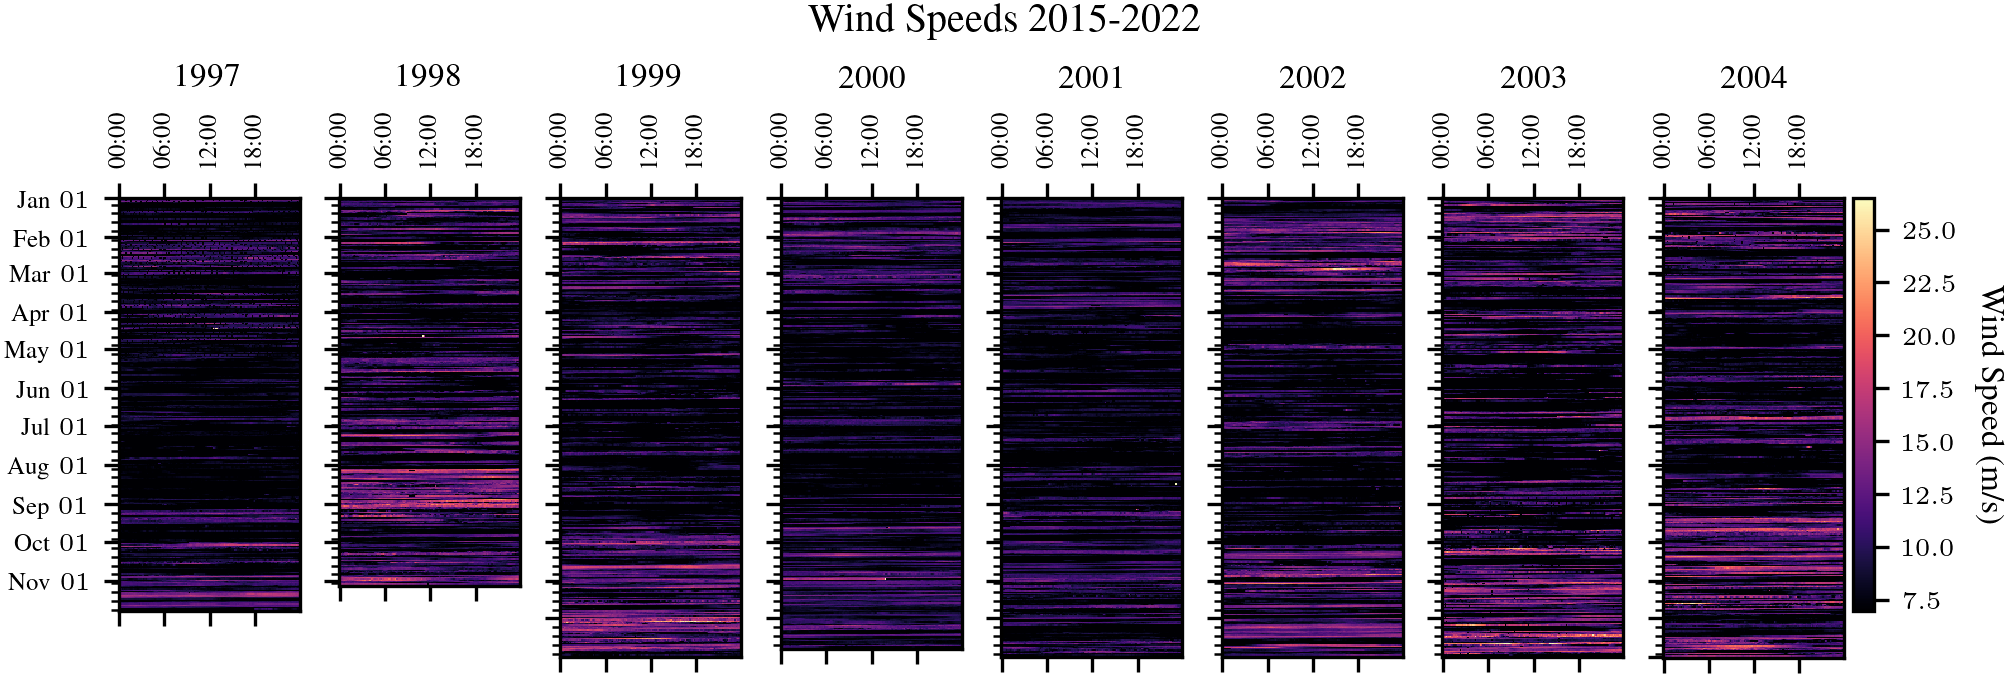

In [10]:
fig, axs = plt.subplots(1, 8, sharex=True, sharey=False)
# fig.suptitle("Wind Speeds in the years 2015-2022")

for i, year in enumerate(range(1997, 2005)):
    ax = axs[i]
    # ax.set_anchor("N")
    mask = wind_df["MESS_DATUM"].dt.year == year
    wind_df_year = wind_df[mask].copy()
    wind_df_year.fillna(0, inplace=True)

    wind_df_year["Day"] = wind_df_year["MESS_DATUM"].dt.date
    wind_df_year["Time"] = wind_df_year["MESS_DATUM"].dt.time

    pivot_table = pd.pivot_table(
        wind_df_year, values=("FF_10_wind"), index=["Day"], columns=["Time"], aggfunc="mean", fill_value=0
    )

    Daystrings = [date.strftime("%d %b") for date in pivot_table.index.values]
    TimeStrings = [time.strftime("%H:%M") for time in pivot_table.columns]

    im = ax.matshow(pivot_table, cmap="magma", vmin=7)

    ax.set_xticks(np.arange(len(pivot_table.columns))[:: (6 * 6)])
    ax.set_xticklabels(TimeStrings[:: (6 * 6)], rotation=90)
    ax.yaxis.set_major_locator(
        mdt.MonthLocator(interval=1)
    )
    ax.yaxis.set_minor_locator(
        mdt.WeekdayLocator(interval=1)
    )
    if i == 0:
        ax.yaxis.set_major_formatter(date_form)
    else:
        ax.set_yticklabels([])

    if i == 7:
        cbar = fig.colorbar(im, ax=ax, shrink=0.4, location="right", anchor=(1.0, 1.0))
        cbar.ax.set_ylabel("Wind Speed (m/s)", rotation=-90, va="bottom")

    ax.set_title(year)

for ax in axs:
    ax.set_anchor("N")
fig.suptitle("Wind Speeds 2015-2022")

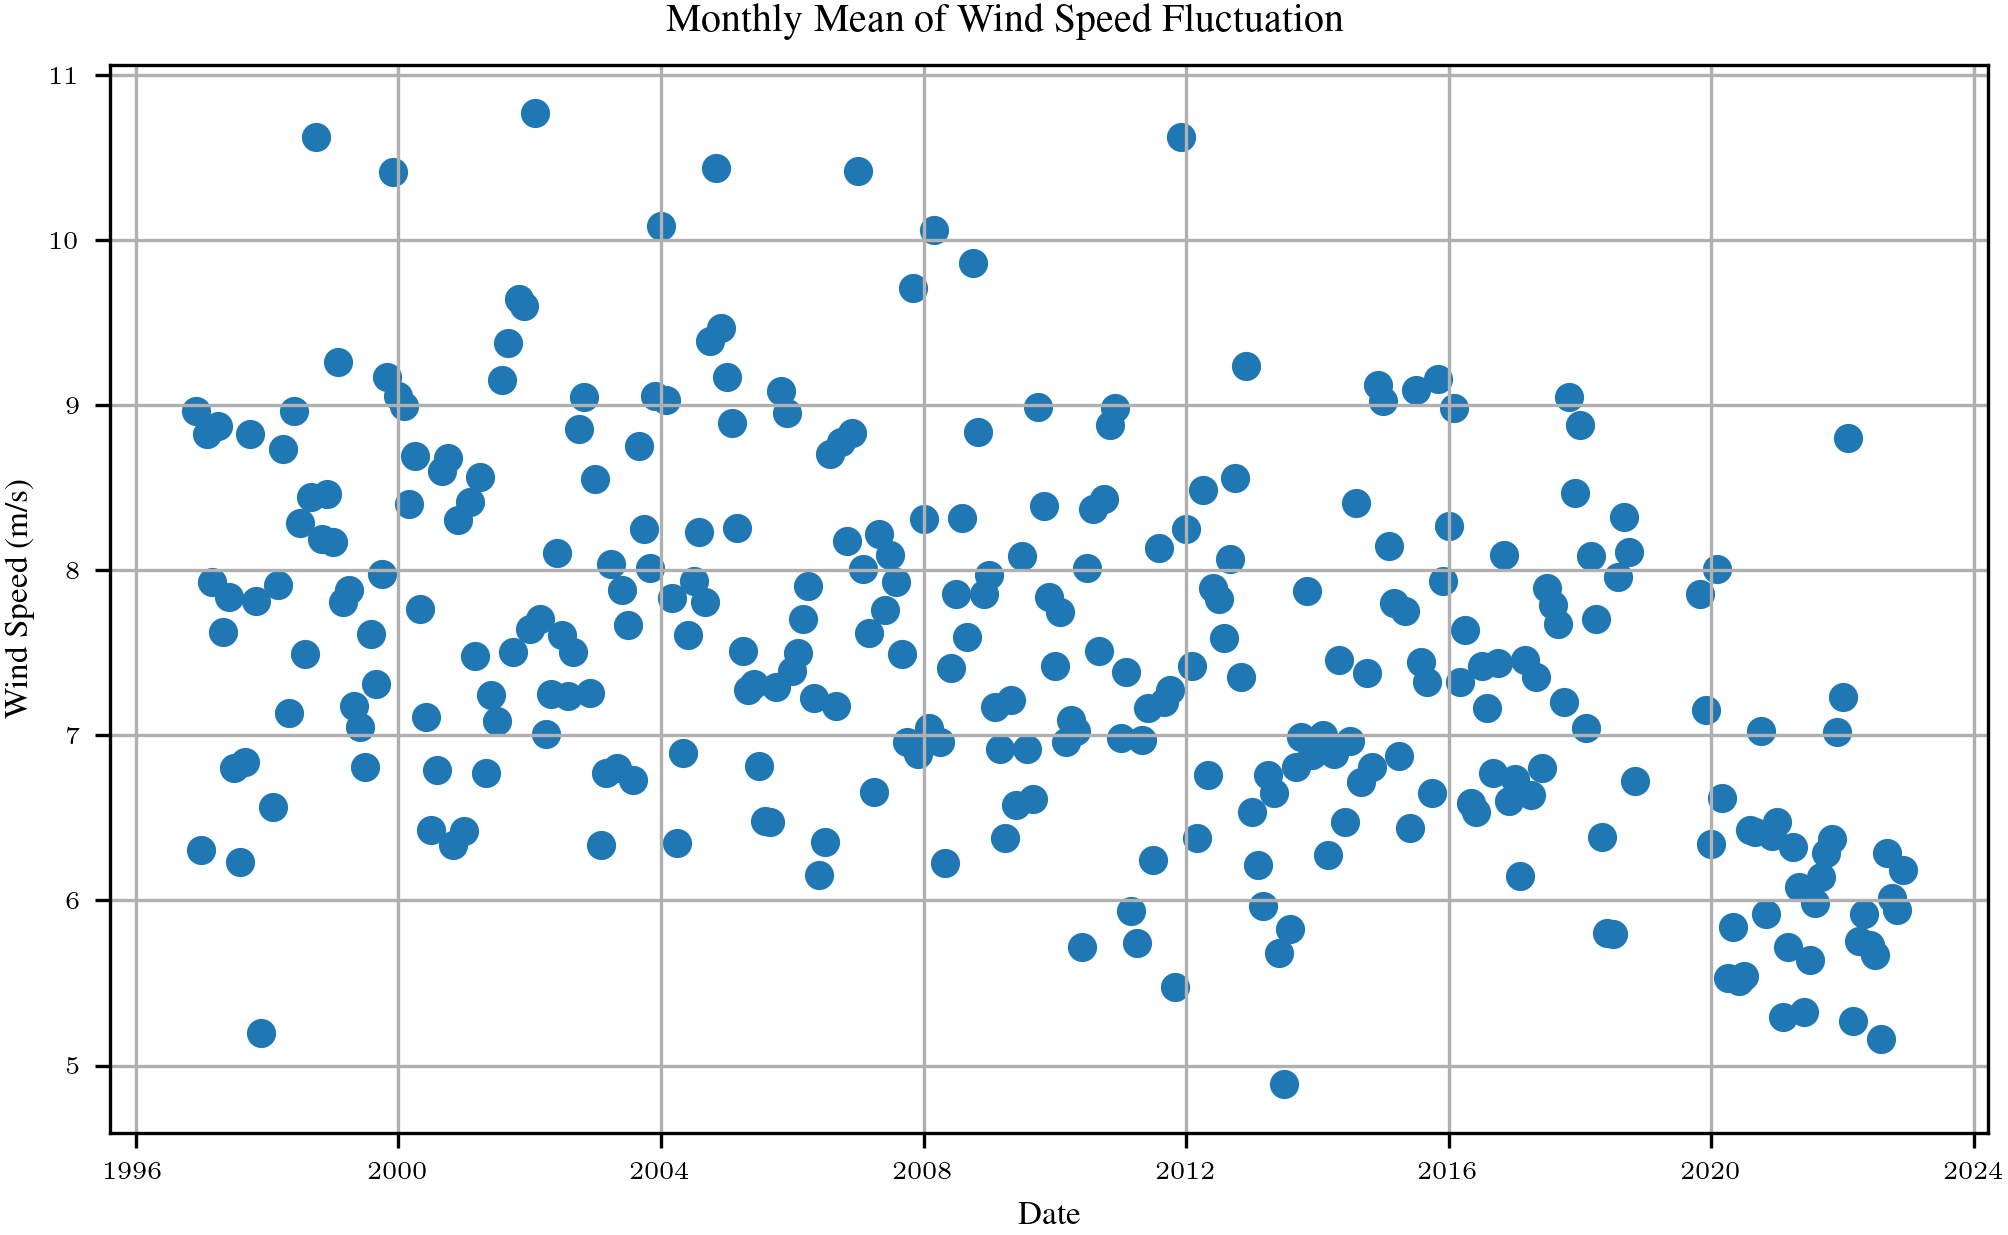

In [11]:
wind_df_by_year = wind_df.groupby(["year", "month", "day"])
wind_df_agg_yr = wind_df_by_year["FF_10_wind"].aggregate(["max", "min"])
wind_df_agg_yr["diff"] = wind_df_agg_yr["max"] - wind_df_agg_yr["min"]
wind_df_agg_yr.reset_index(inplace=True)
wind_df_agg_yr["date"] = pd.to_datetime(wind_df_agg_yr[["year", "month", "day"]])

wind_df_mean_diff = wind_df_agg_yr.groupby(["year", "month"])["diff"].mean().reset_index()
wind_df_mean_diff["date"] = pd.to_datetime(wind_df_mean_diff[["year", "month"]].assign(day=1))

fig, ax = plt.subplots(1, 1)
fig.suptitle("Monthly Mean of Wind Speed Fluctuation")
ax.scatter(wind_df_mean_diff["date"], wind_df_mean_diff["diff"])
ax.set_ylabel("Wind Speed (m/s)")
ax.set_xlabel("Date")
ax.grid(which="major")

Text(0.5, 0.98, 'Monthly Mean of Wind Speed Fluctuations')

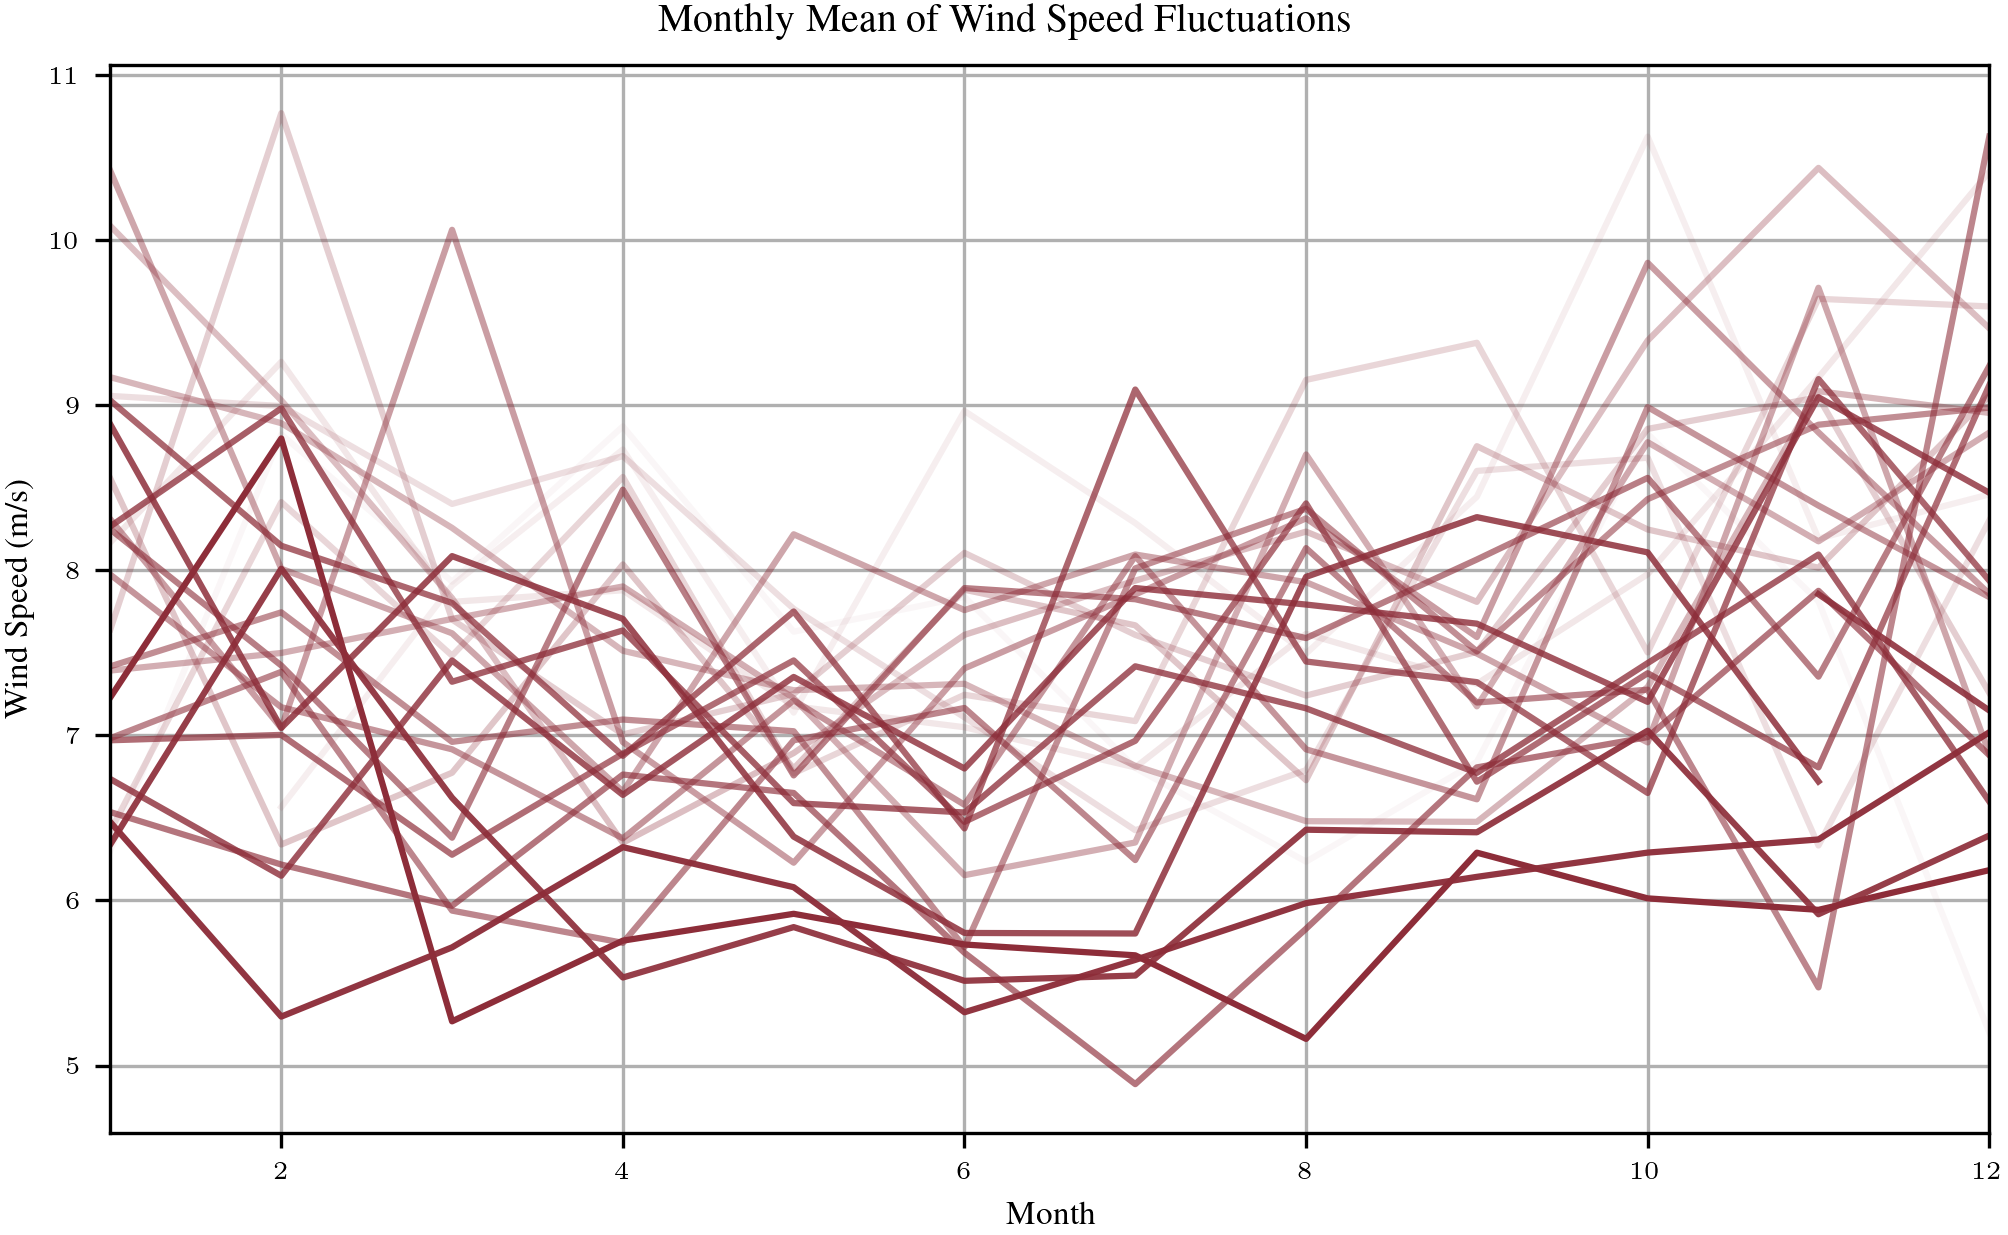

In [12]:
fig, axs = plt.subplots(1, 1)

for year, year_month_df in wind_df_mean_diff.groupby("year"):
    alpha = (year - 1996) / (2022 - 1996)
    axs.plot(year_month_df["month"], year_month_df["diff"], color=tp.constants.color.rgb.tue_red, alpha=alpha)
# sns.boxplot(data=wind_df_agg_yr, x=wind_df_agg_yr.index.values, y="diff")

axs.set_ylabel("Wind Speed (m/s)")
axs.set_xlabel("Month")
axs.set_xlim((1, 12))
axs.grid(which="major")
fig.suptitle("Monthly Mean of Wind Speed Fluctuations")
# wind_df_mean_diff.groupby("year")["diff"].plot(kind="kde", ax=axs[1])

Text(0.5, 0, 'Wind Speeds (m/s)')

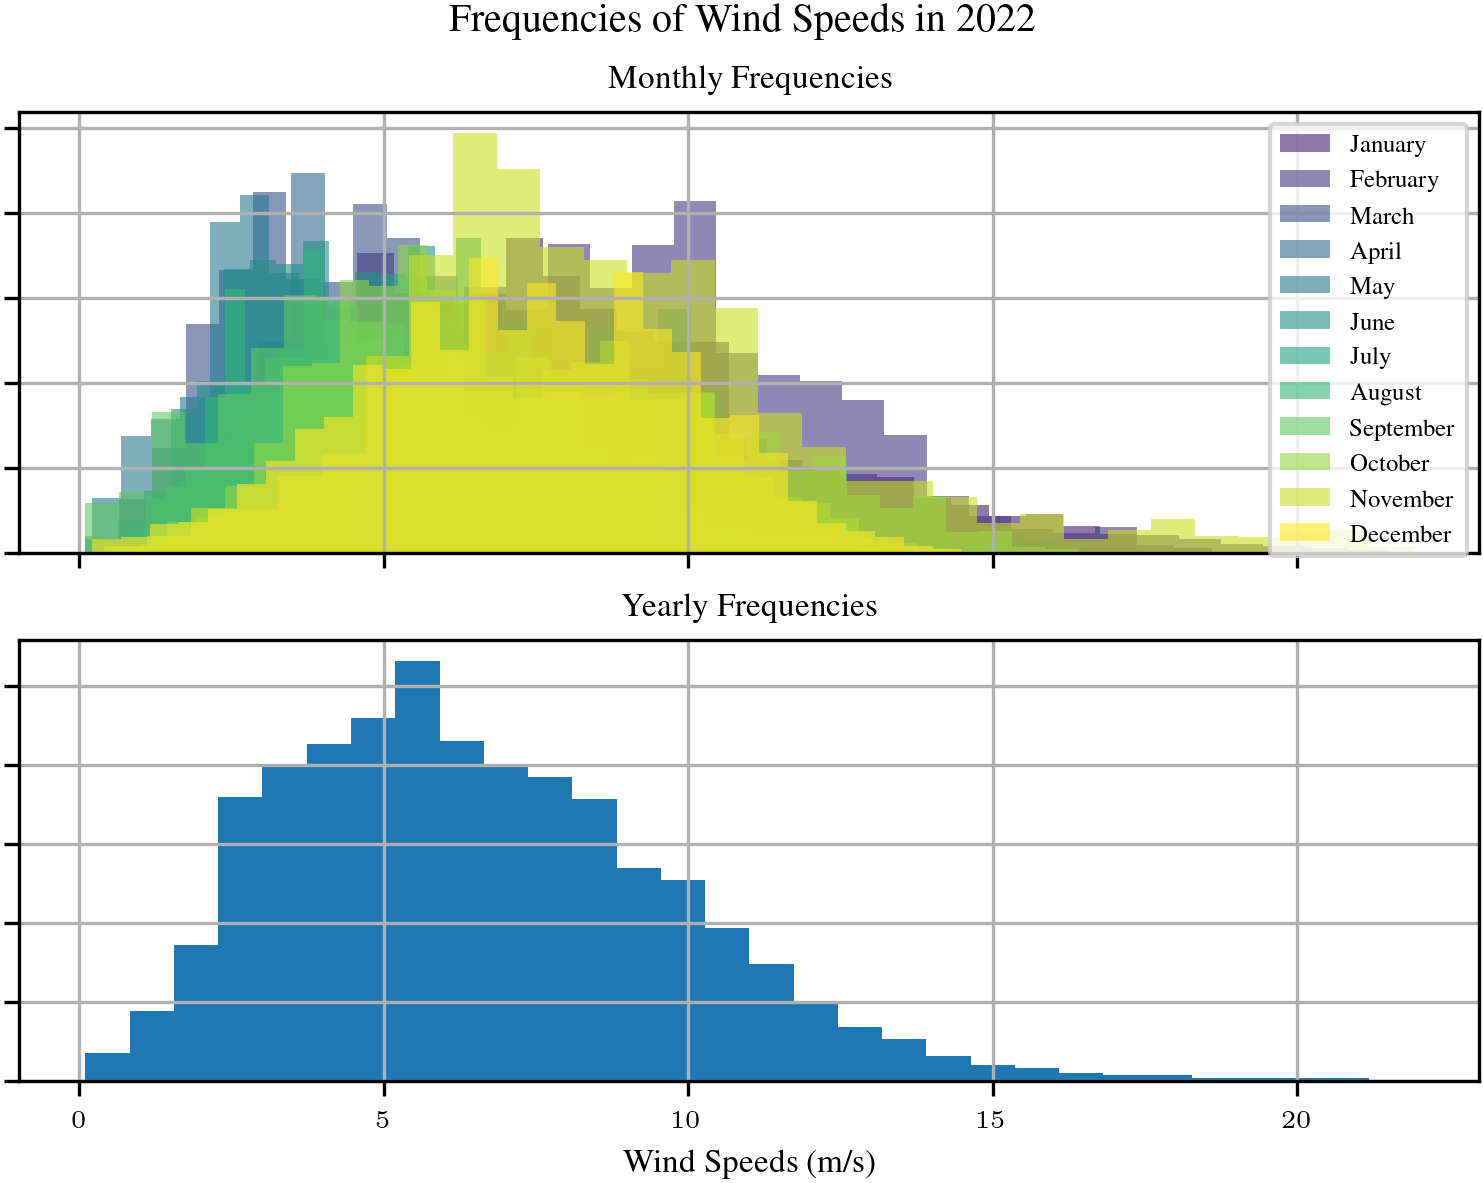

In [13]:
plt.rcParams.update(bundles.icml2022(nrows=2, ncols=1))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 4))
# Create a list of colors for the colormap (here, we use a smooth transition from blue to red to blue)
colors = plt.cm.viridis(np.linspace(0, 1, 13))

fig.suptitle("Frequencies of Wind Speeds in 2022")
wind_df_2022["month"] = wind_df_2022["MESS_DATUM"].dt.month
for year, year_month_df in wind_df_2022.groupby("month"):
    year_month_df.hist(column="FF_10_wind", bins=30, ax=ax1, alpha=0.6, label=dt.datetime(2022, year, 1).strftime("%B"), color=colors[year])
# wind_df_2022[wind_df_2022["MESS_DATUM"].dt.month == 6].hist(column="FF_10_wind", bins=20, ax=ax)
ax1.set_title("")
ax1.set_yticklabels([])
# ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_title("Monthly Frequencies")
ax1.legend(loc="upper right")

wind_df_2022.hist(column="FF_10_wind", bins=30, ax=ax2)
ax2.set_title("Yearly Frequencies")
ax2.set_yticklabels([])
ax2.set_xlabel("Wind Speeds (m/s)")

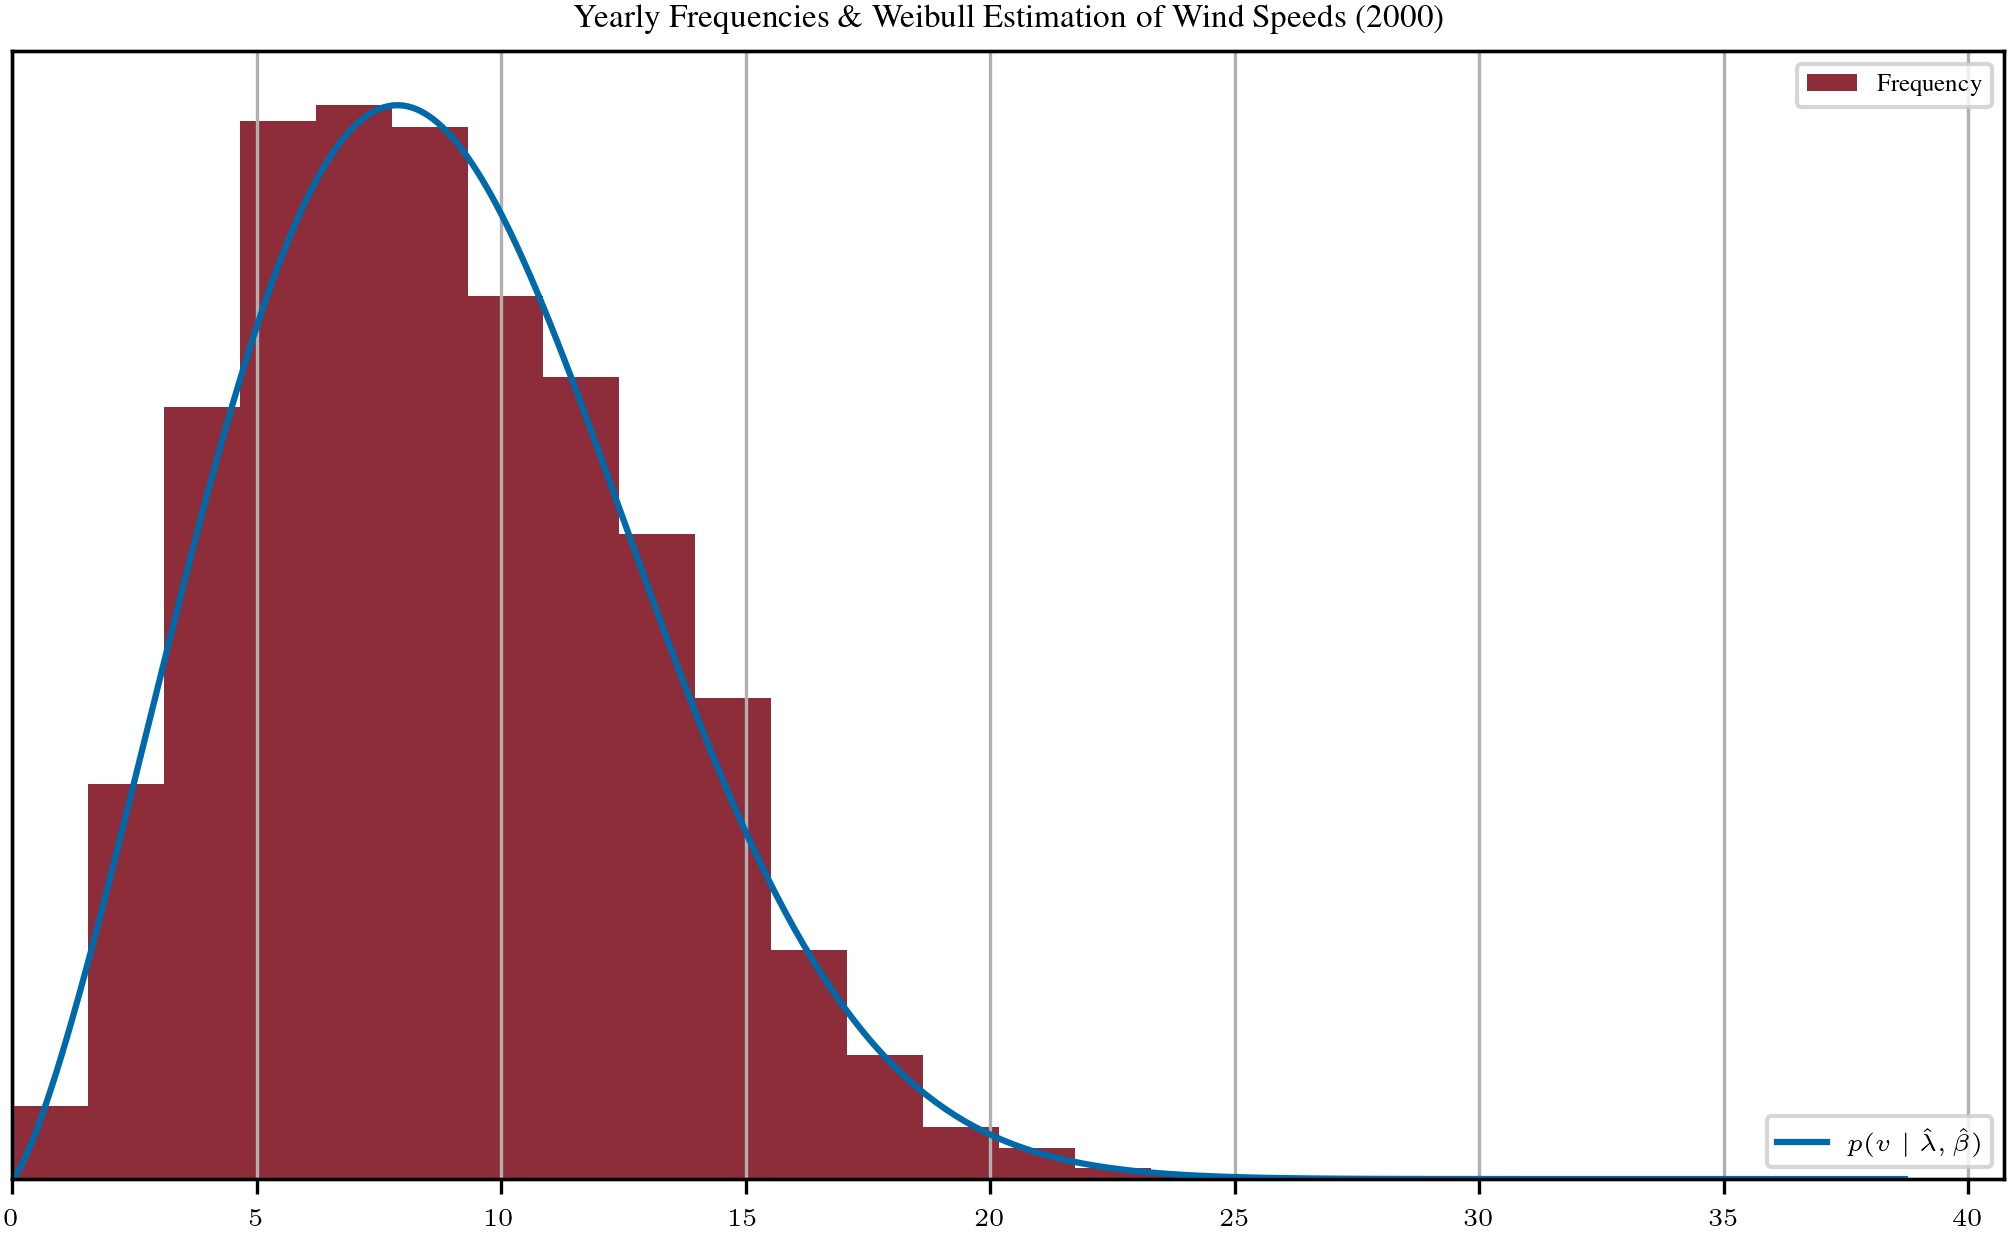

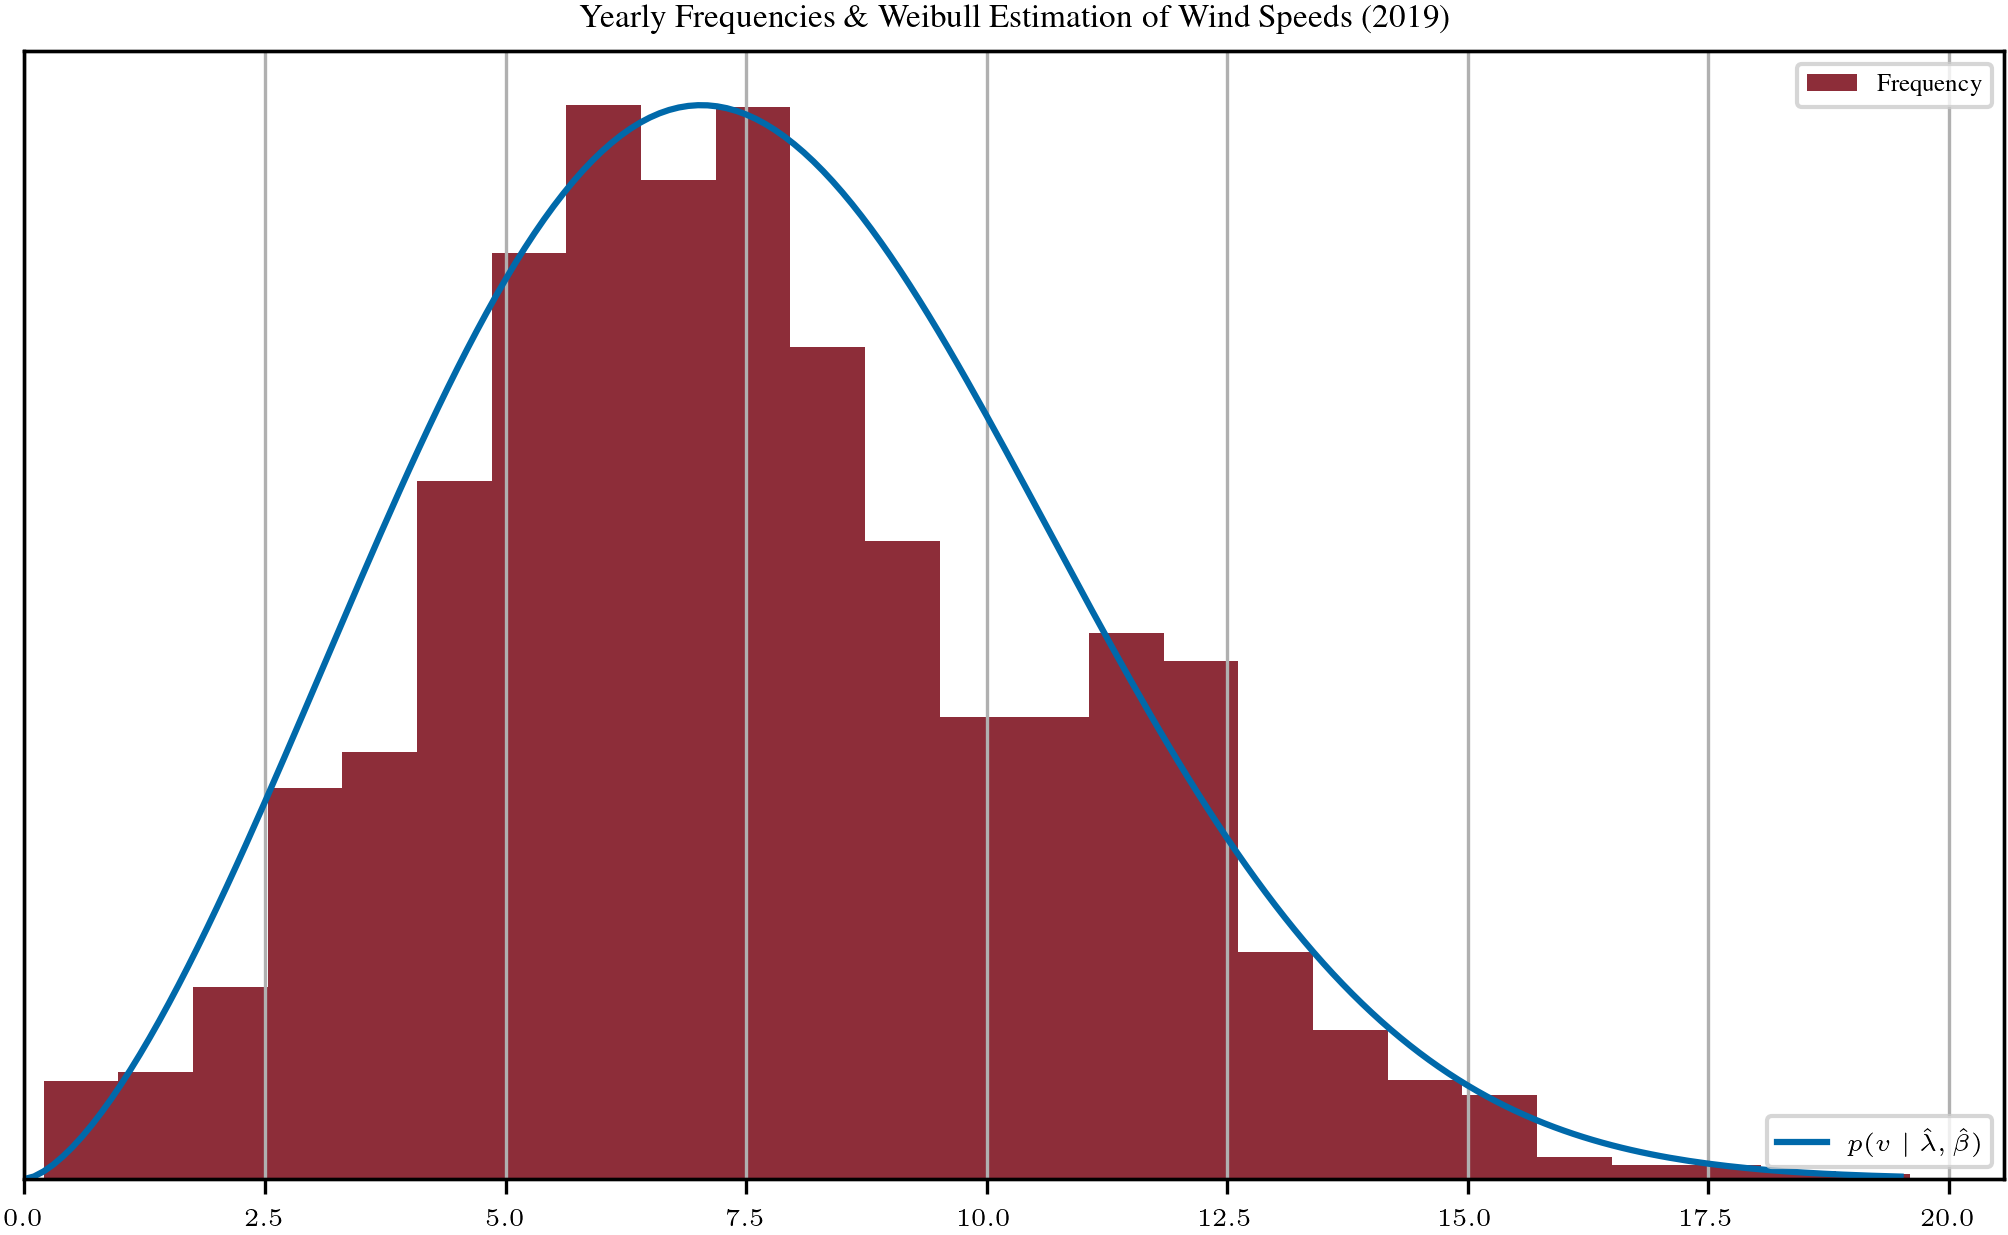

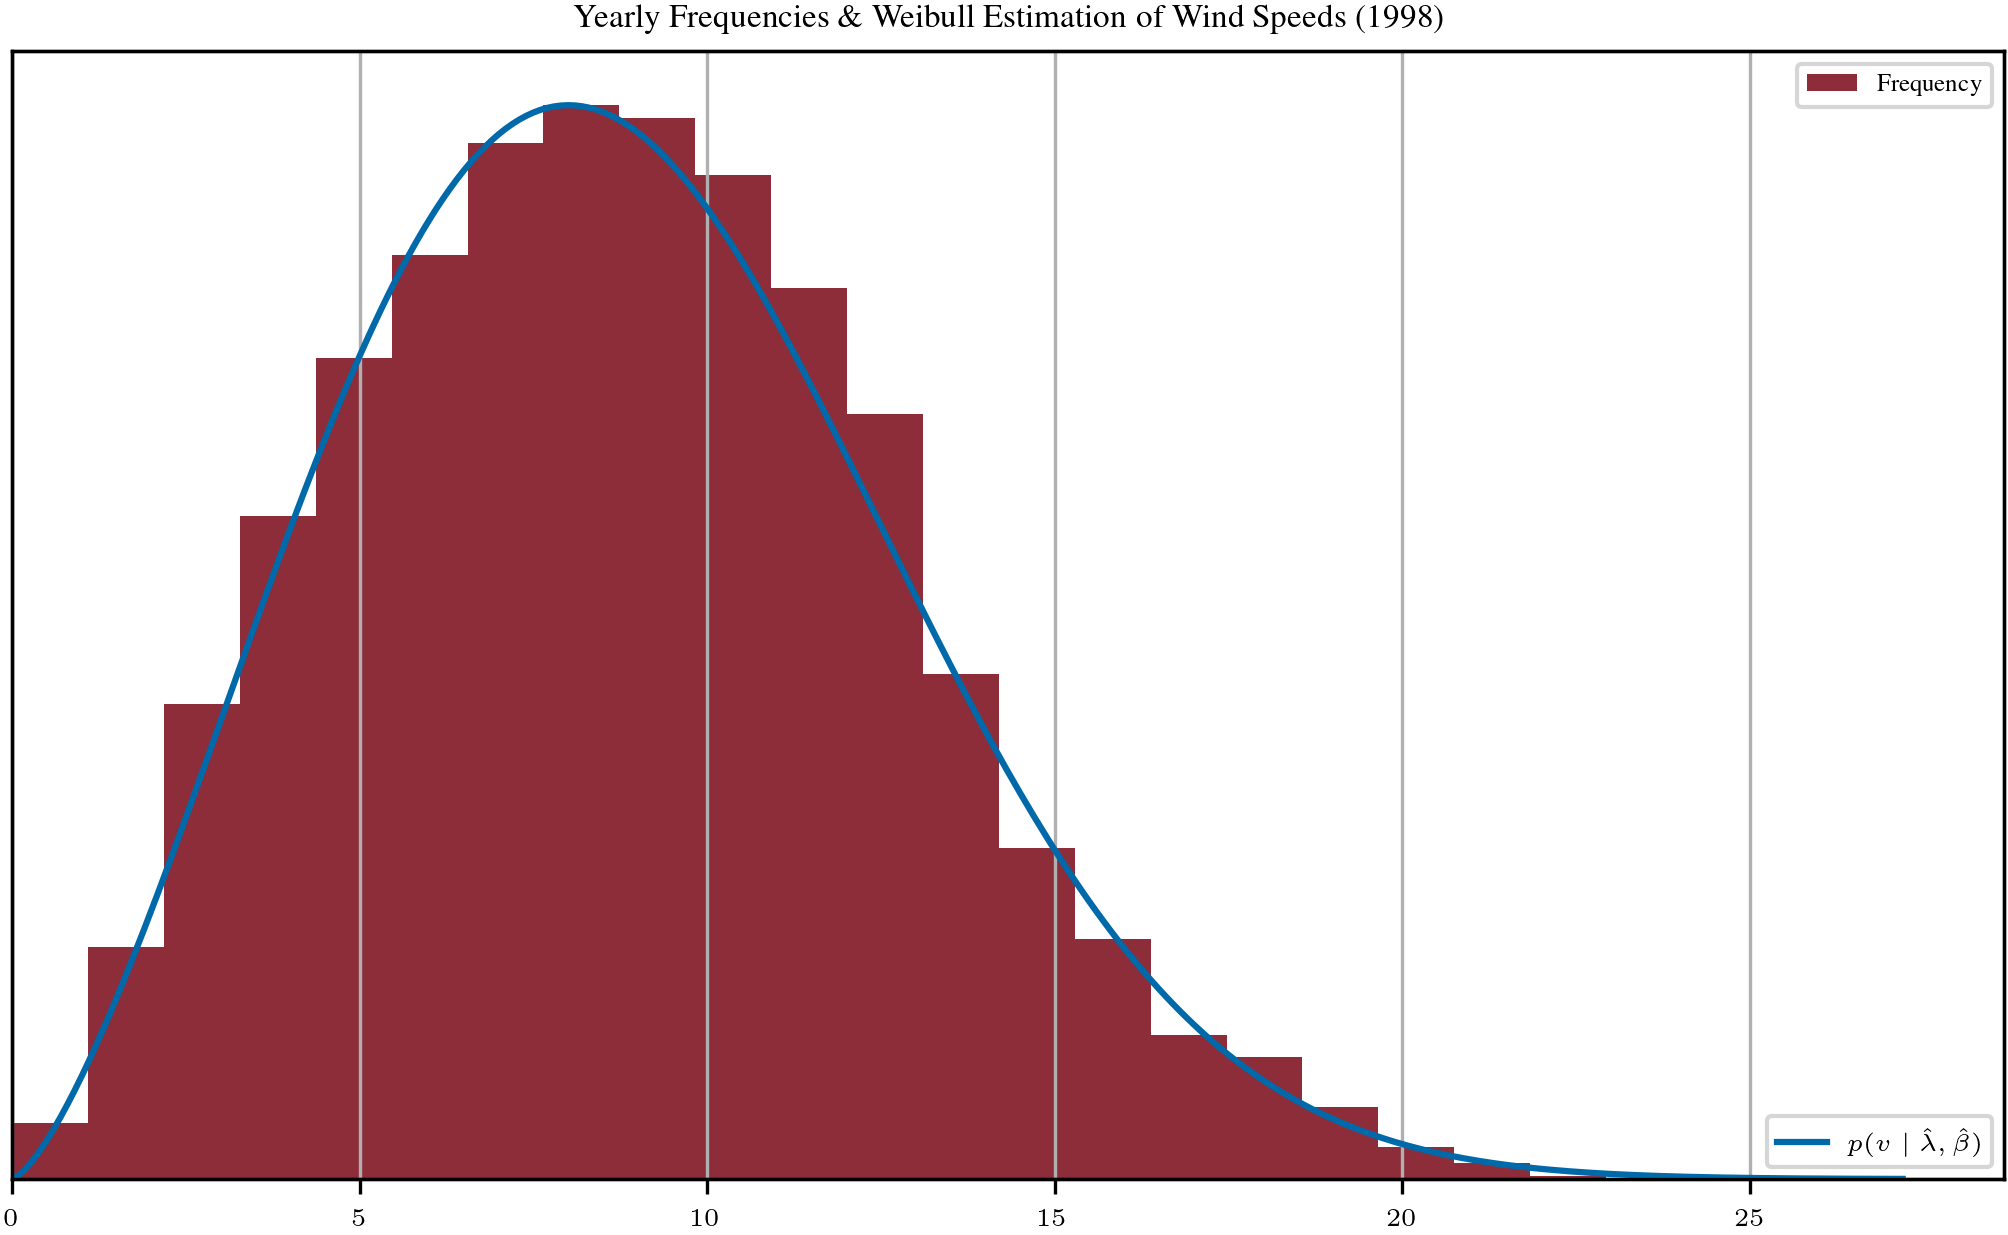

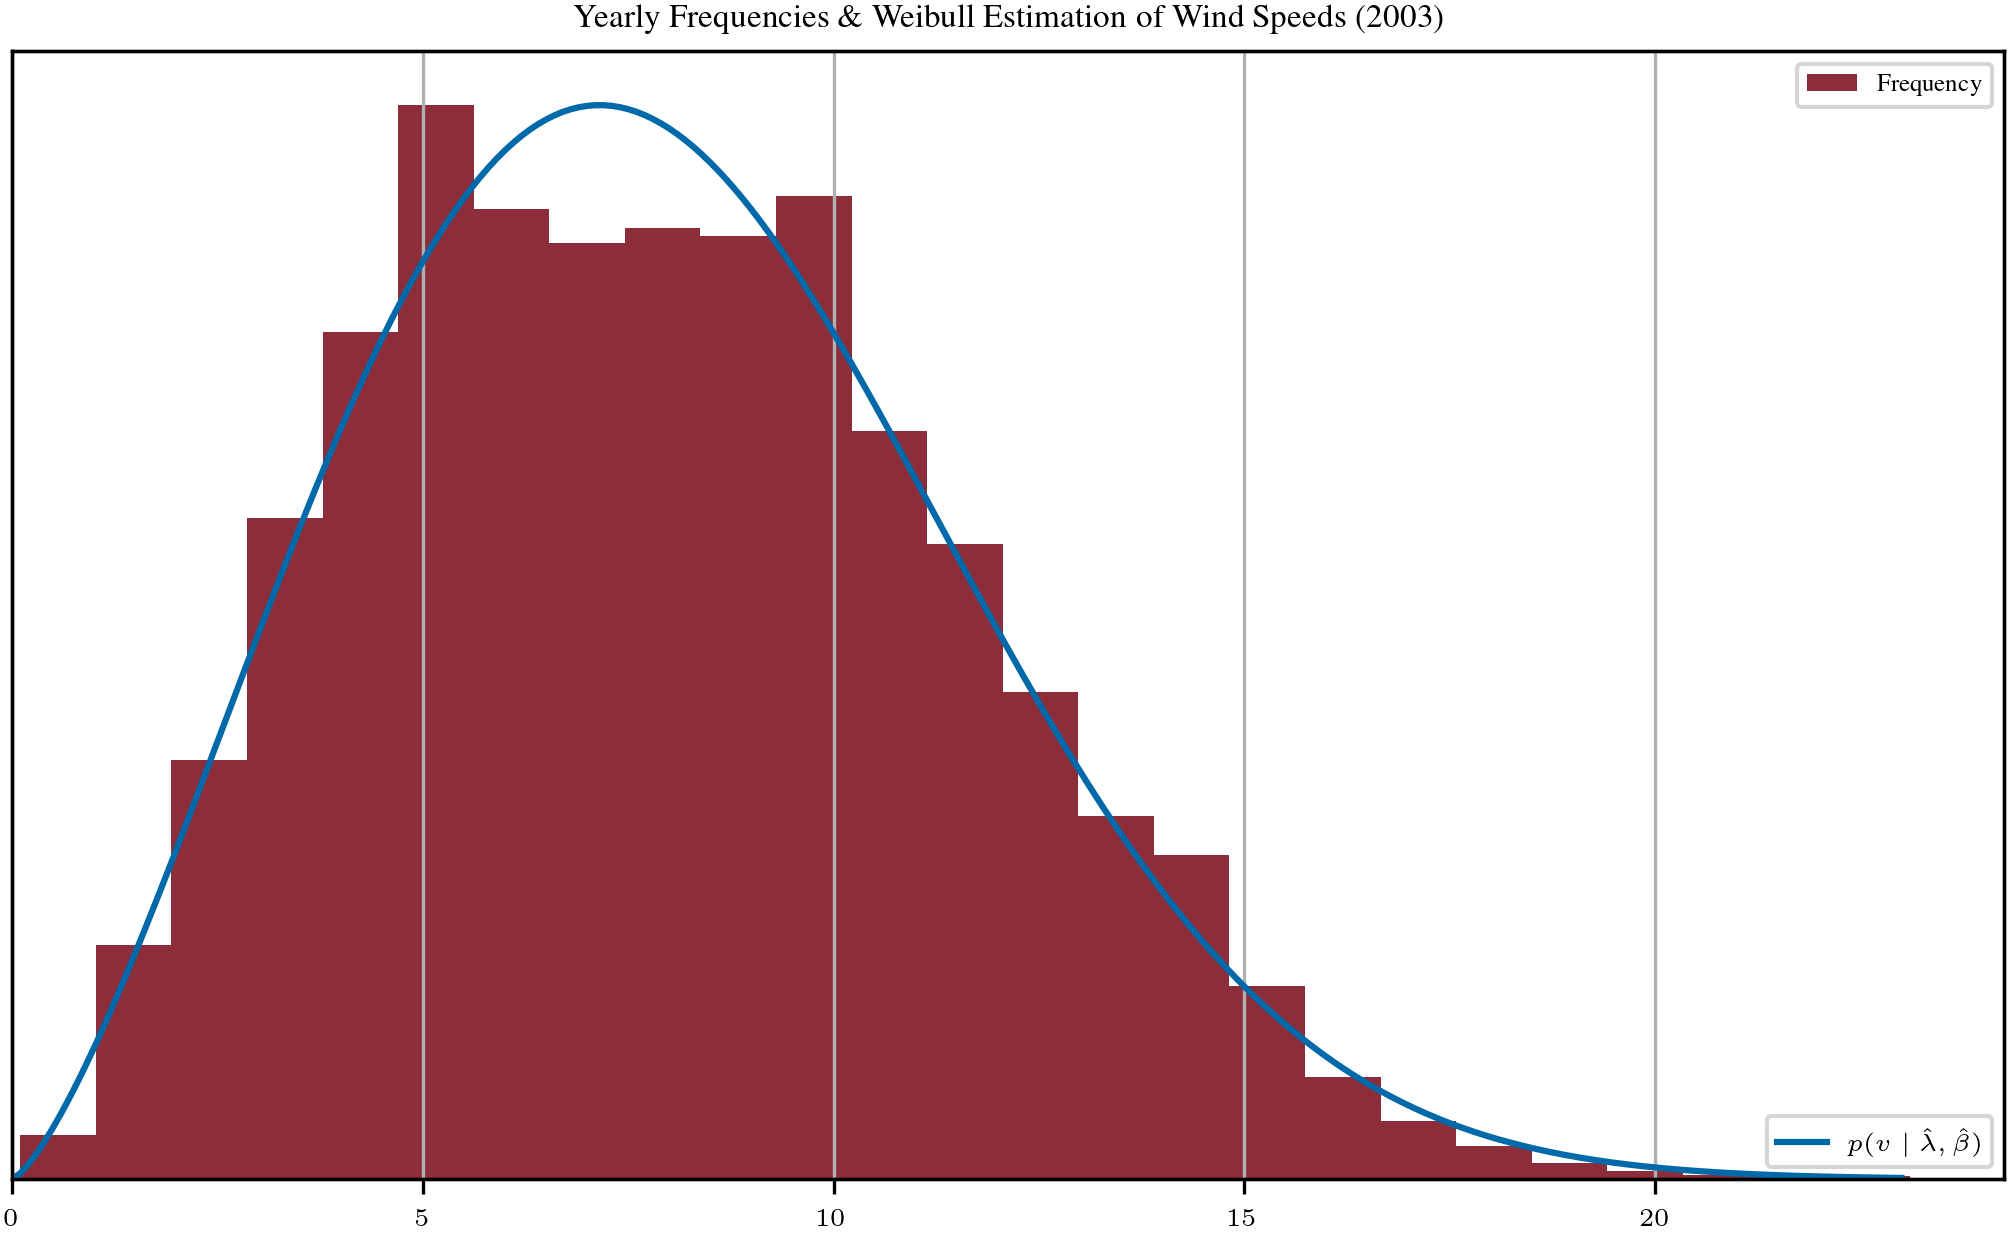

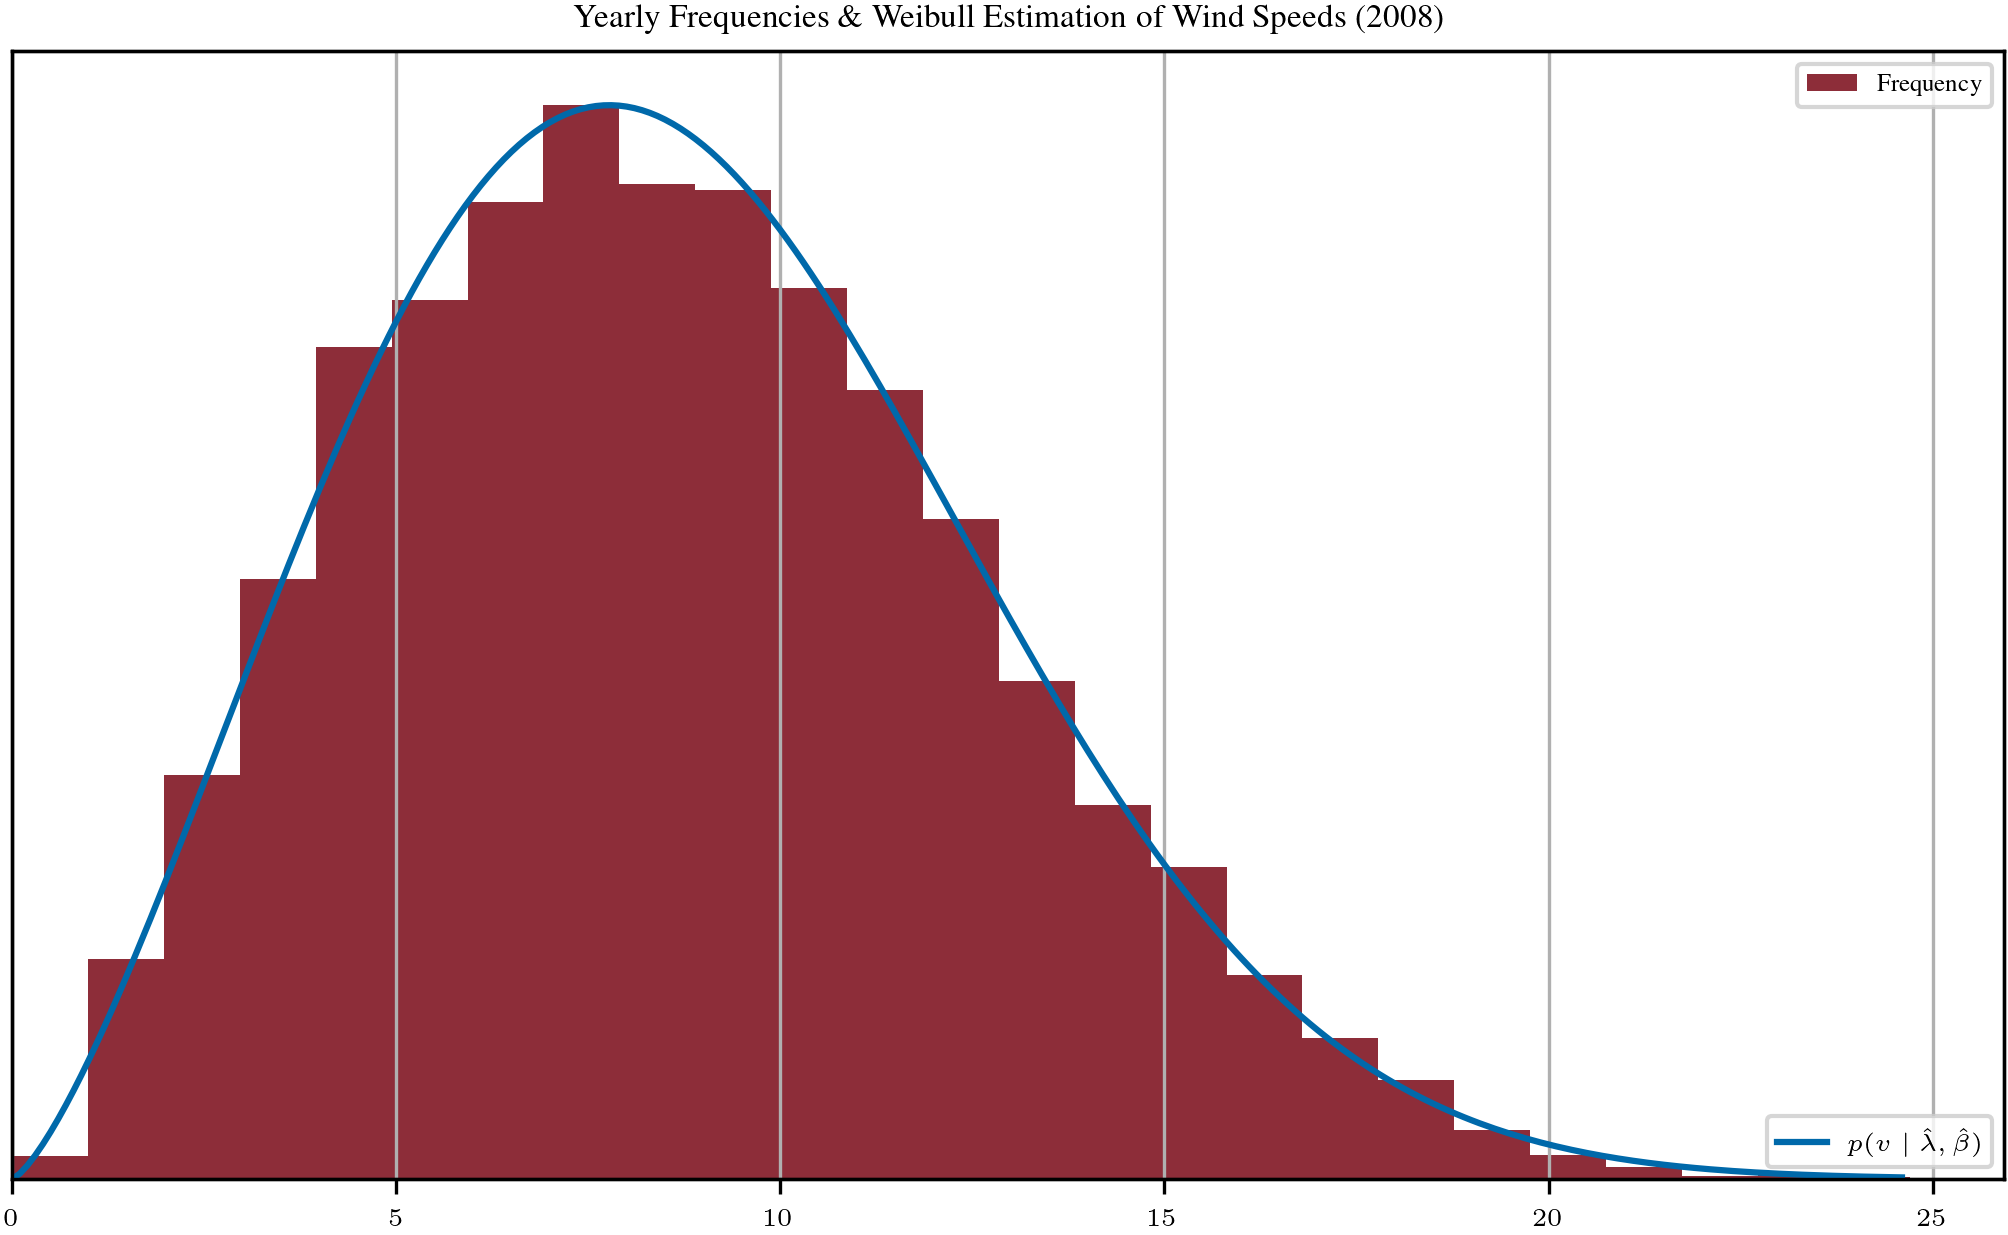

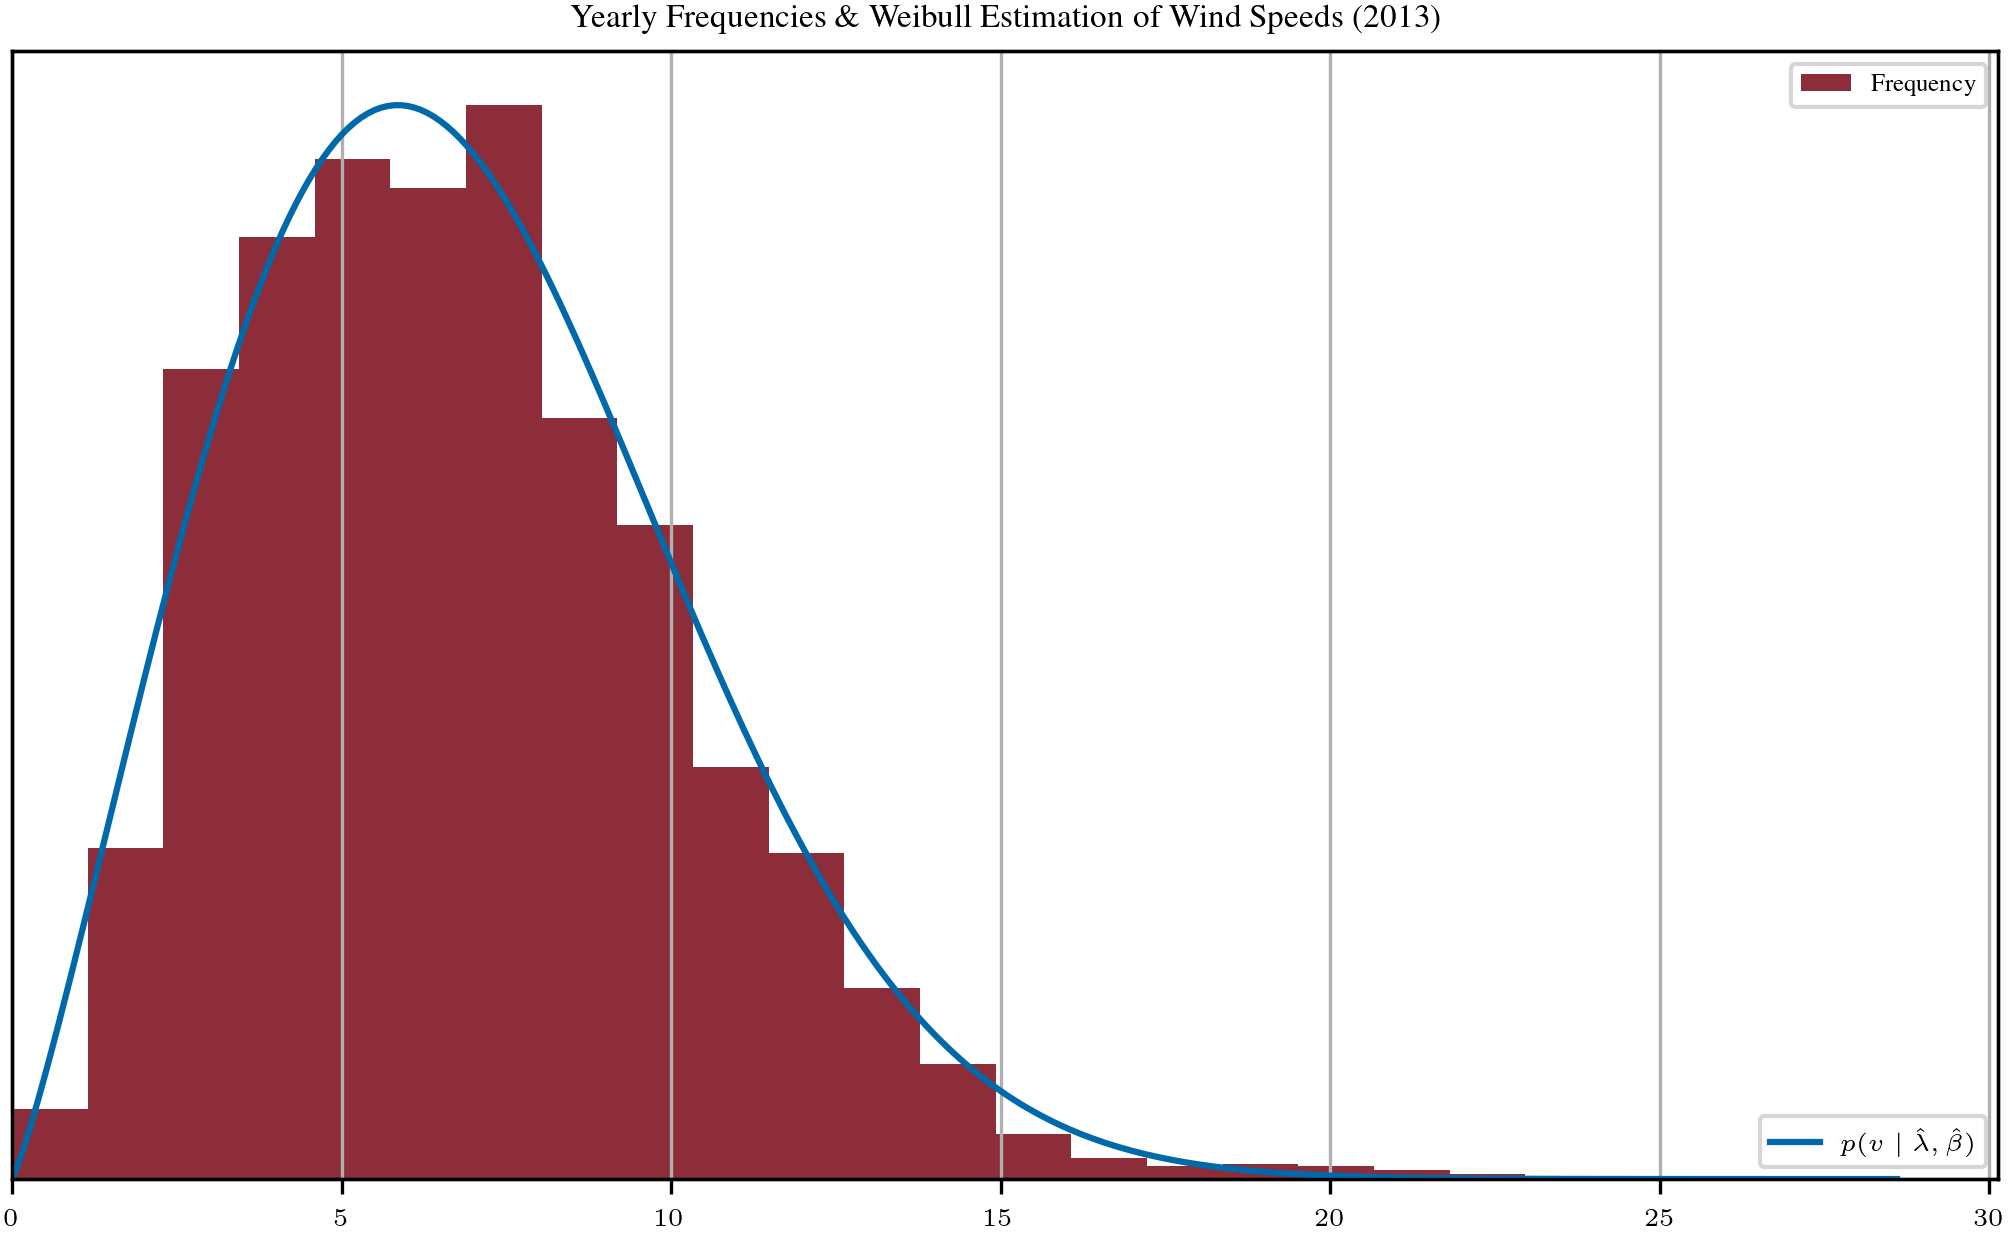

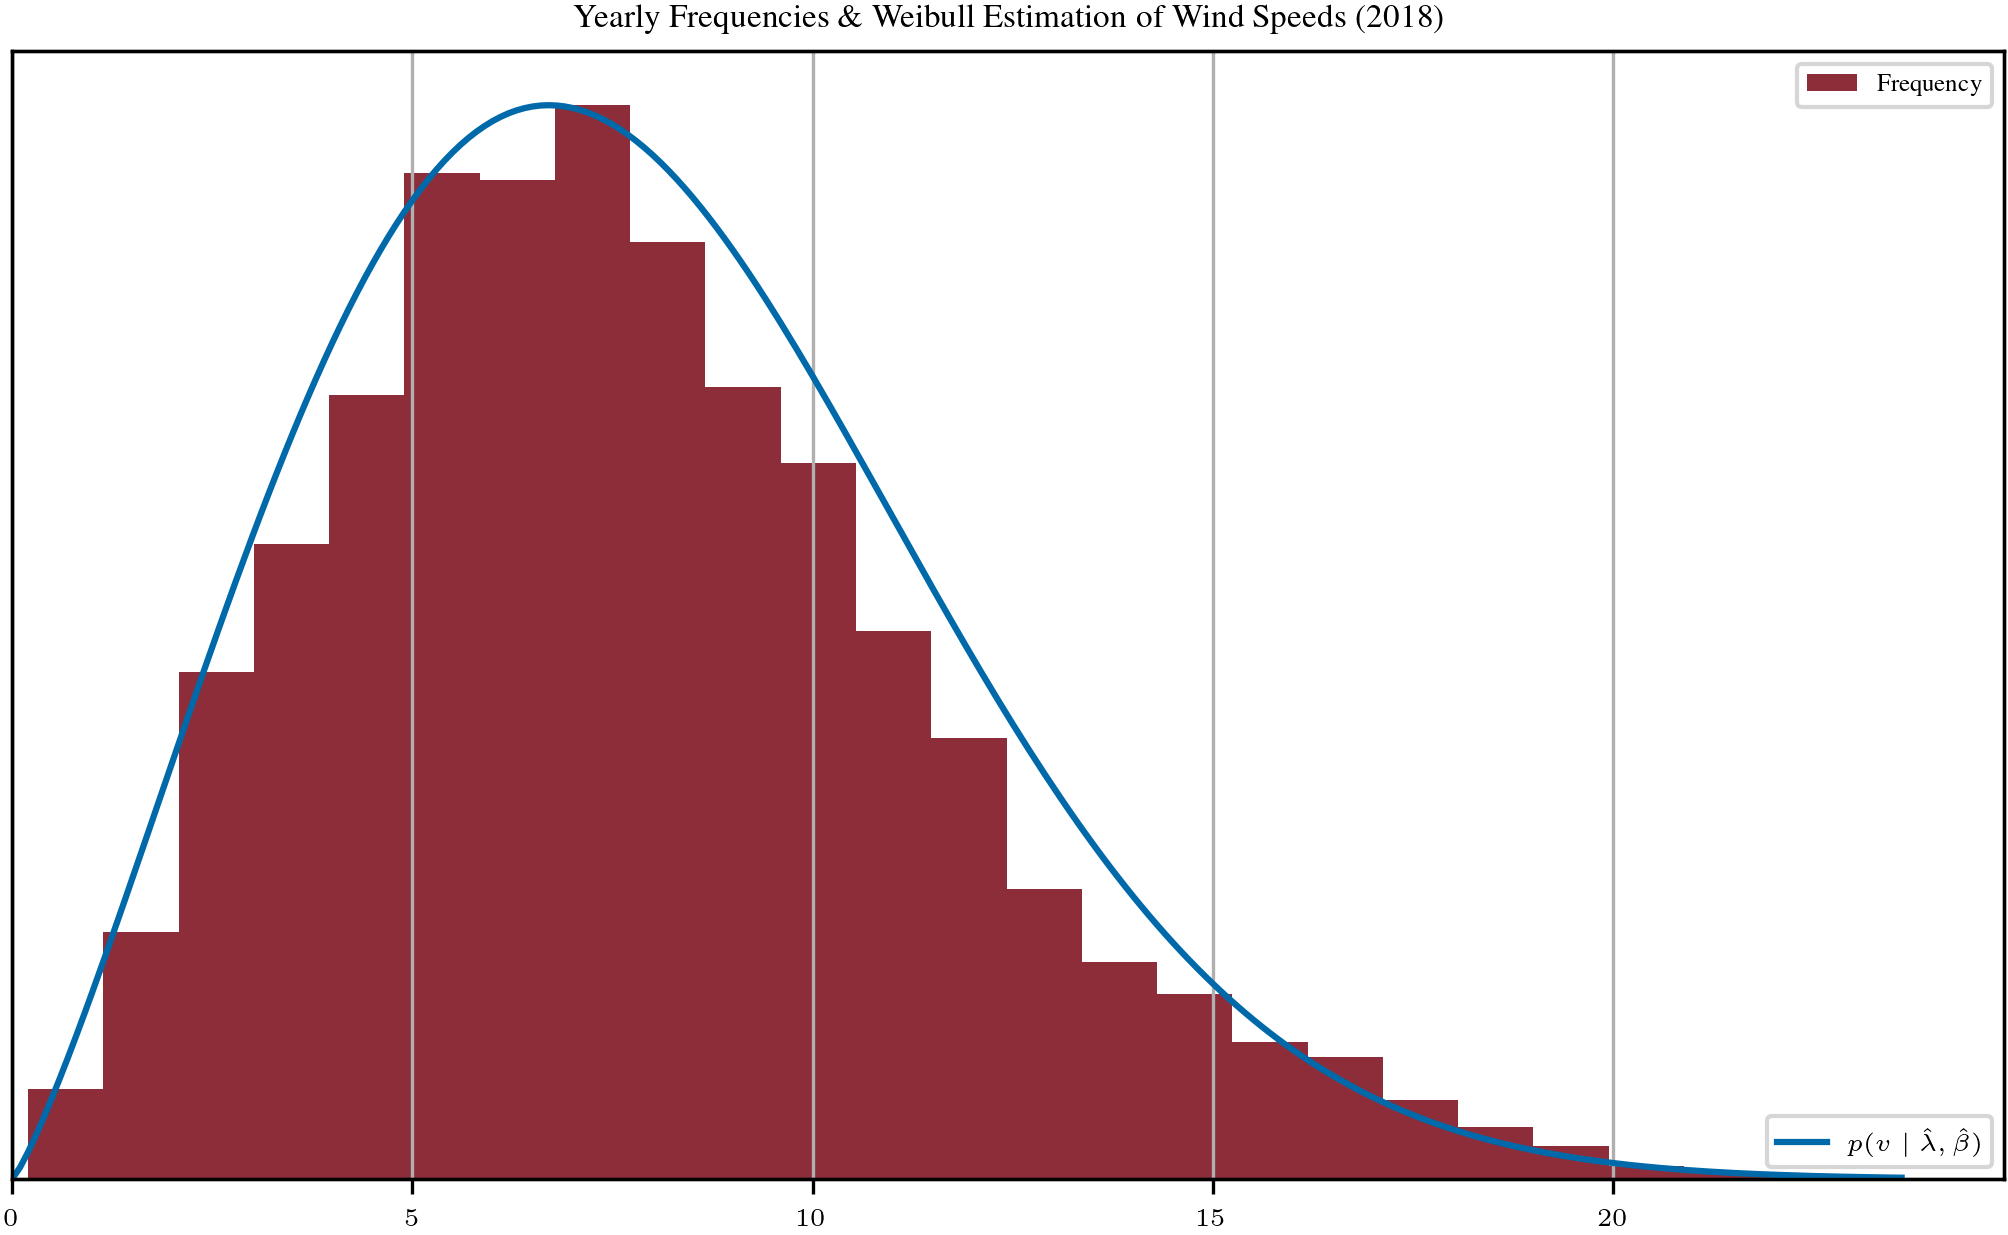

In [14]:
def plot_year(year):
    fig, ax = plt.subplots()
    year_df = wind_df[wind_df["MESS_DATUM"].dt.year == year]
    year_df_wind_mean = year_df["FF_10_wind"].mean()
    Y = year_df["FF_10_wind"].dropna().to_numpy()
    
    weibull = Weibull.estimate(Y)
    X = np.arange(0, np.max(Y), 0.1)

    ax1 = ax.twinx()
    ax1.plot(X, weibull.pdf(X), color=tp.constants.color.rgb.tue_blue, label=r"$p(v \mid \hat{\lambda}, \hat{\beta})$")
    ax1.set_ylim(0)
    ax1.set_yticklabels([])
    ax1.set_yticks([])
    ax1.legend(loc="lower right")


    year_df.hist(column="FF_10_wind", bins=25, ax=ax, color=tp.constants.color.rgb.tue_red, label="Frequency")
    ax.set_title("")
    ax.set_xlim(0)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.legend(loc="upper right")
    ax.set_title(f"Yearly Frequencies \& Weibull Estimation of Wind Speeds ({year})")

# year with invalid measurements
plt.rcParams.update(bundles.icml2022(column="full"))
plot_year(2000)
plot_year(2019)

years = range(1998, 2023, 5)
for year in years:
    plot_year(year)
plt.show()

Text(0, 0.5, 'p(v $\\mid \\hat{\\lambda}, \\hat{\\beta}$)')

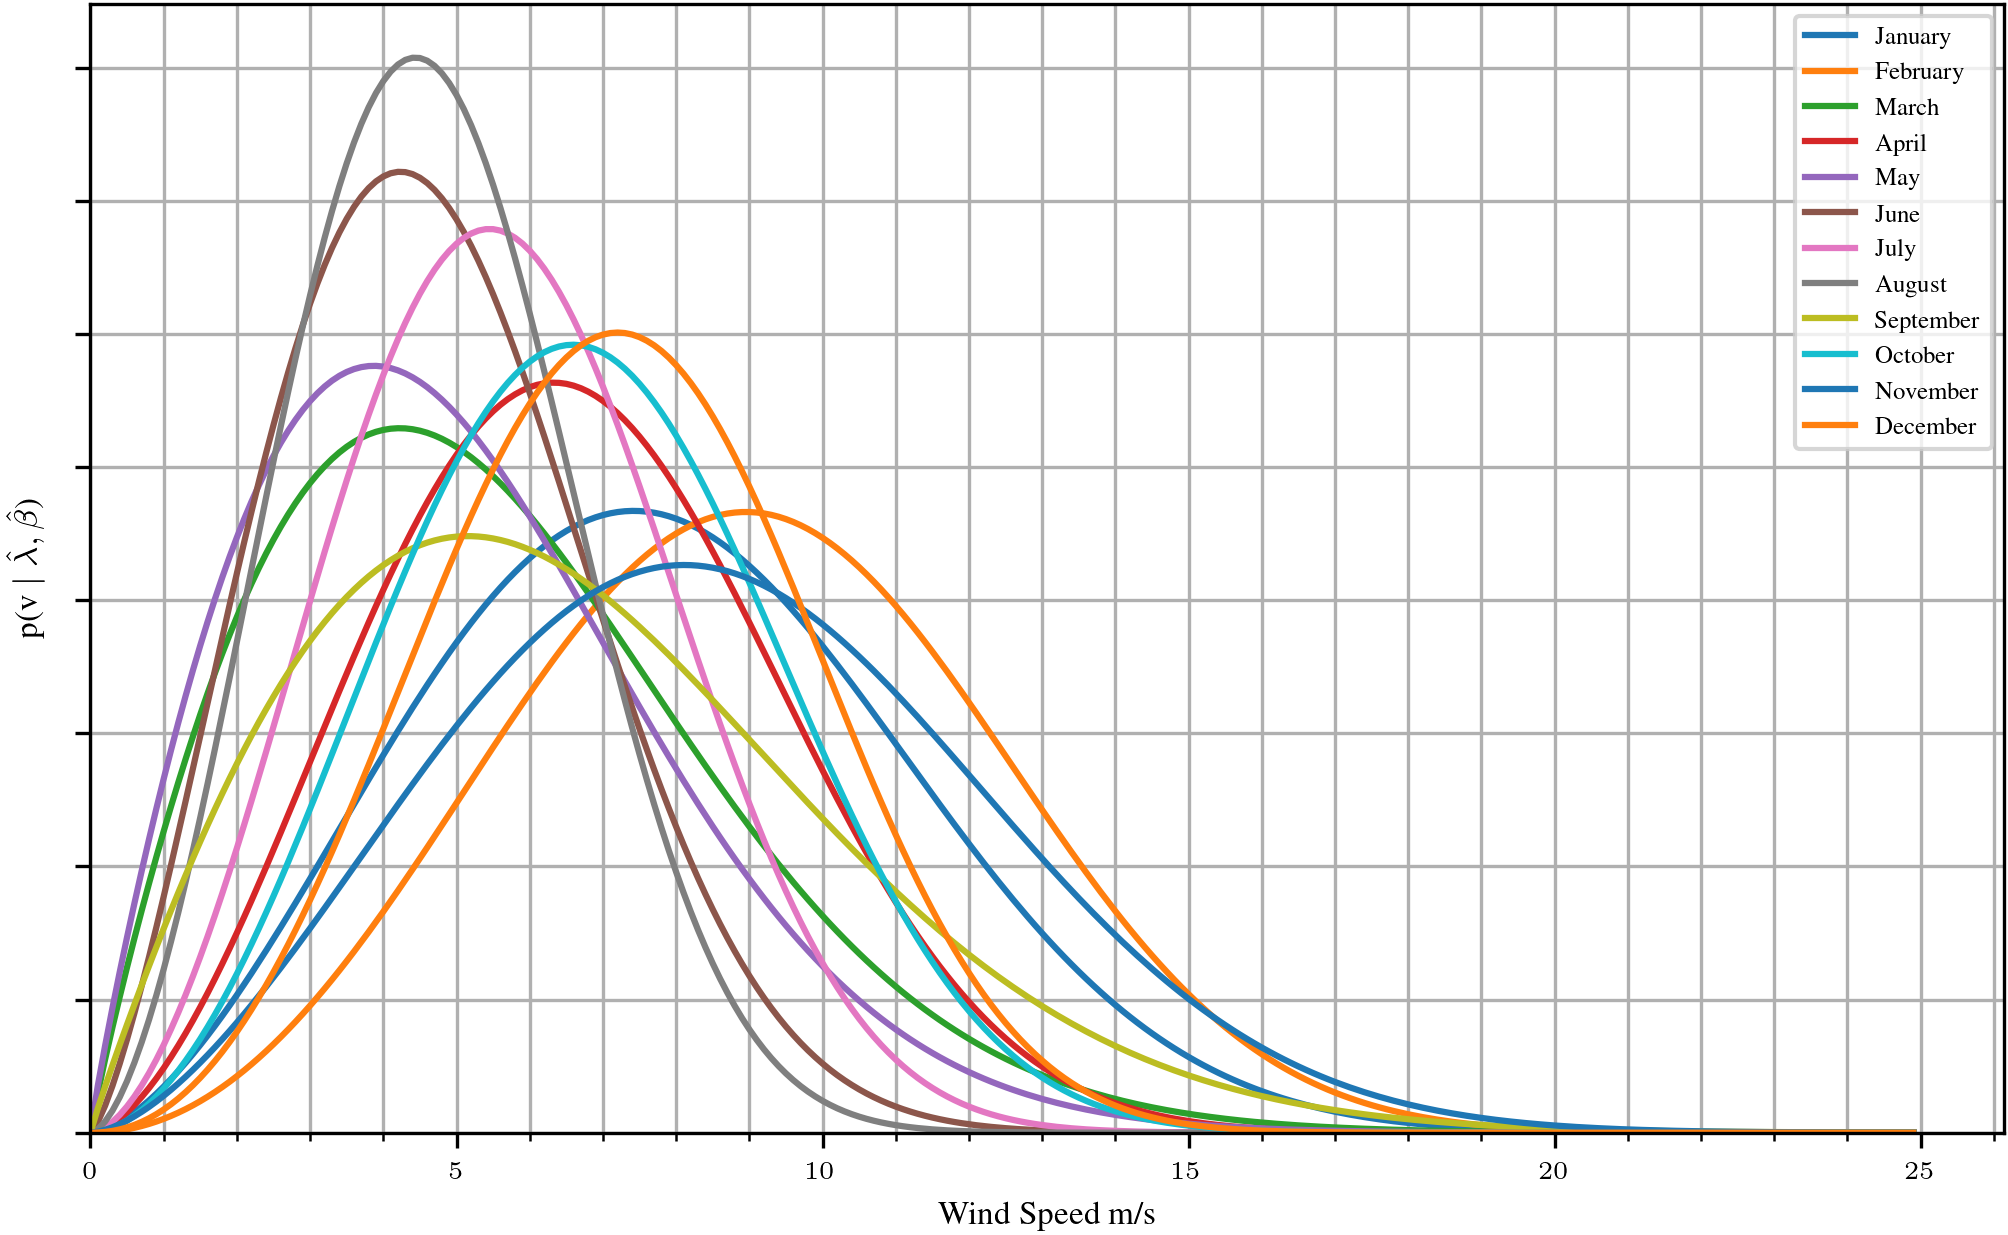

In [15]:
fig, ax = plt.subplots(1, 1)

for month, month_df in wind_df_2022.groupby("month"):
    Y = month_df["FF_10_wind"].dropna().to_numpy()
    X = np.arange(0, 25, 0.1)
    weibull = Weibull.estimate(Y)
    ax.plot(X, weibull.pdf(X), label=dt.datetime(2022, month, 1).strftime("%B"))
    # ax.axvline(weibull.mean, ls="-.", linewidth=0.25)
    
ax.grid(which="both")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.set_yticklabels([])
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()
ax.set_xlabel(r"Wind Speed m/s")
ax.set_ylabel(r"p(v $\mid \hat{\lambda}, \hat{\beta}$)")

In [16]:

wind_year_dists = []
for year, year_month_df in wind_df.groupby("year"):
    if year == 2019:
        continue
    Y = year_month_df["FF_10_wind"].dropna().copy().to_numpy()
    weibull = Weibull.estimate(Y)
    wind_year_dists.append([year, Y, weibull])
wind_year_dists = pd.DataFrame(wind_year_dists, columns=["year", "data", "weibull"])
wind_year_dists

year                                               data  \
0   1996  [15.8, 16.2, 16.6, 16.0, 16.3, 16.3, 16.8, 9.4...   
1   1997  [7.9, 8.7, 8.8, 8.9, 8.9, 8.8, 9.2, 9.4, 9.2, ...   
2   1998  [13.1, 12.0, 13.0, 13.5, 13.3, 13.3, 14.1, 14....   
3   1999  [11.3, 11.8, 12.0, 12.0, 12.3, 11.9, 12.5, 12....   
4   2000  [8.4, 7.6, 8.7, 7.6, 8.8, 8.1, 7.7, 9.4, 8.3, ...   
5   2001  [13.7, 14.1, 14.8, 15.0, 15.3, 15.2, 15.5, 15....   
6   2002  [7.6, 7.9, 7.3, 6.1, 5.6, 5.1, 4.4, 4.9, 7.7, ...   
7   2003  [12.4, 12.4, 12.6, 12.5, 12.2, 12.0, 12.3, 11....   
8   2004  [7.6, 8.1, 7.6, 8.3, 7.9, 7.9, 7.7, 7.5, 7.3, ...   
9   2005  [3.4, 4.0, 4.6, 4.8, 4.9, 4.6, 4.7, 5.6, 5.7, ...   
10  2006  [11.5, 11.5, 11.7, 11.8, 11.1, 11.7, 12.2, 12....   
11  2007  [17.5, 16.7, 16.2, 15.9, 14.6, 14.5, 14.6, 14....   
12  2008  [4.7, 5.0, 5.7, 5.7, 5.8, 5.4, 5.2, 4.6, 4.5, ...   
13  2009  [2.8, 2.9, 3.5, 4.1, 4.2, 4.7, 4.2, 4.9, 4.9, ...   
14  2010  [10.9, 10.9, 10.6, 10.9, 10.3, 10.6, 10.6, 10....   
15  2011  [10.8, 10.9, 11.4, 10.8, 10.3, 10.4, 11.0, 10....   
16  2012  [7.4, 7.4, 7.7, 8.2, 8.5, 8.2, 8.2, 9.0, 9.0, ...   
17  2013  [10.5, 9.0, 10.4, 10.8, 10.0, 10.0, 9.9, 9.9, ...   
18  2014  [9.1, 9.0, 9.3, 9.4, 9.3, 9.4, 9.0, 8.8, 8.7, ...   
19  2015  [9.1, 9.6, 10.1, 10.1, 9.8, 10.0, 9.4, 9.6, 10...   
20  2016  [10.5, 11.1, 11.0, 10.8, 10.4, 10.3, 10.8, 10....   
21  2017  [11.8, 10.6, 10.8, 11.4, 10.8, 10.8, 10.7, 9.9...   
22  2018  [10.9, 11.4, 12.0, 12.1, 12.1, 12.4, 12.6, 12....   
23  2020  [3.0, 3.4, 3.5, 3.7, 3.9, 4.1, 3.9, 4.2, 5.0, ...   
24  2021  [1.5, 1.6, 1.6, 1.3, 0.8, 0.6, 1.0, 0.9, 0.8, ...   
25  2022  [8.2, 7.9, 6.9, 6.8, 5.8, 6.0, 5.9, 5.7, 7.2, ...   

                                              weibull  
0    Weibull distr for lambda=10.901997394939055, ...  
1    Weibull distr for lambda=8.861603858938173, b...  
2    Weibull distr for lambda=10.005245575801538, ...  
3    Weibull distr for lambda=9.7201764898477, bet...  
4    Weibull distr for lambda=10.025728428151126, ...  
5    Weibull distr for lambda=9.349950169543918, b...  
6    Weibull distr for lambda=9.71885946132631, be...  
7    Weibull distr for lambda=9.0387494296538, bet...  
8    Weibull distr for lambda=9.750622581700258, b...  
9    Weibull distr for lambda=9.730091474253818, b...  
10   Weibull distr for lambda=9.597721980731183, b...  
11   Weibull distr for lambda=9.885387023270262, b...  
12   Weibull distr for lambda=9.844886891639058, b...  
13   Weibull distr for lambda=9.261067657514477, b...  
14   Weibull distr for lambda=9.01433946208806, be...  
15   Weibull distr for lambda=8.93183664810212, be...  
16   Weibull distr for lambda=9.114825046579428, b...  
17   Weibull distr for lambda=7.787340515985404, b...  
18   Weibull distr for lambda=9.095725090297996, b...  
19   Weibull distr for lambda=9.498328567639577, b...  
20   Weibull distr for lambda=8.730699705573734, b...  
21   Weibull distr for lambda=8.798438014768536, b...  
22   Weibull distr for lambda=8.821288567996442, b...  
23   Weibull distr for lambda=7.409116926481917, b...  
24   Weibull distr for lambda=7.351728385363476, b...  
25   Weibull distr for lambda=7.417137740981281, b...

Text(0, 0.5, '$\\textrm{p}(\\textrm{v} \\mid \\hat{\\lambda}, \\hat{\\beta})$')

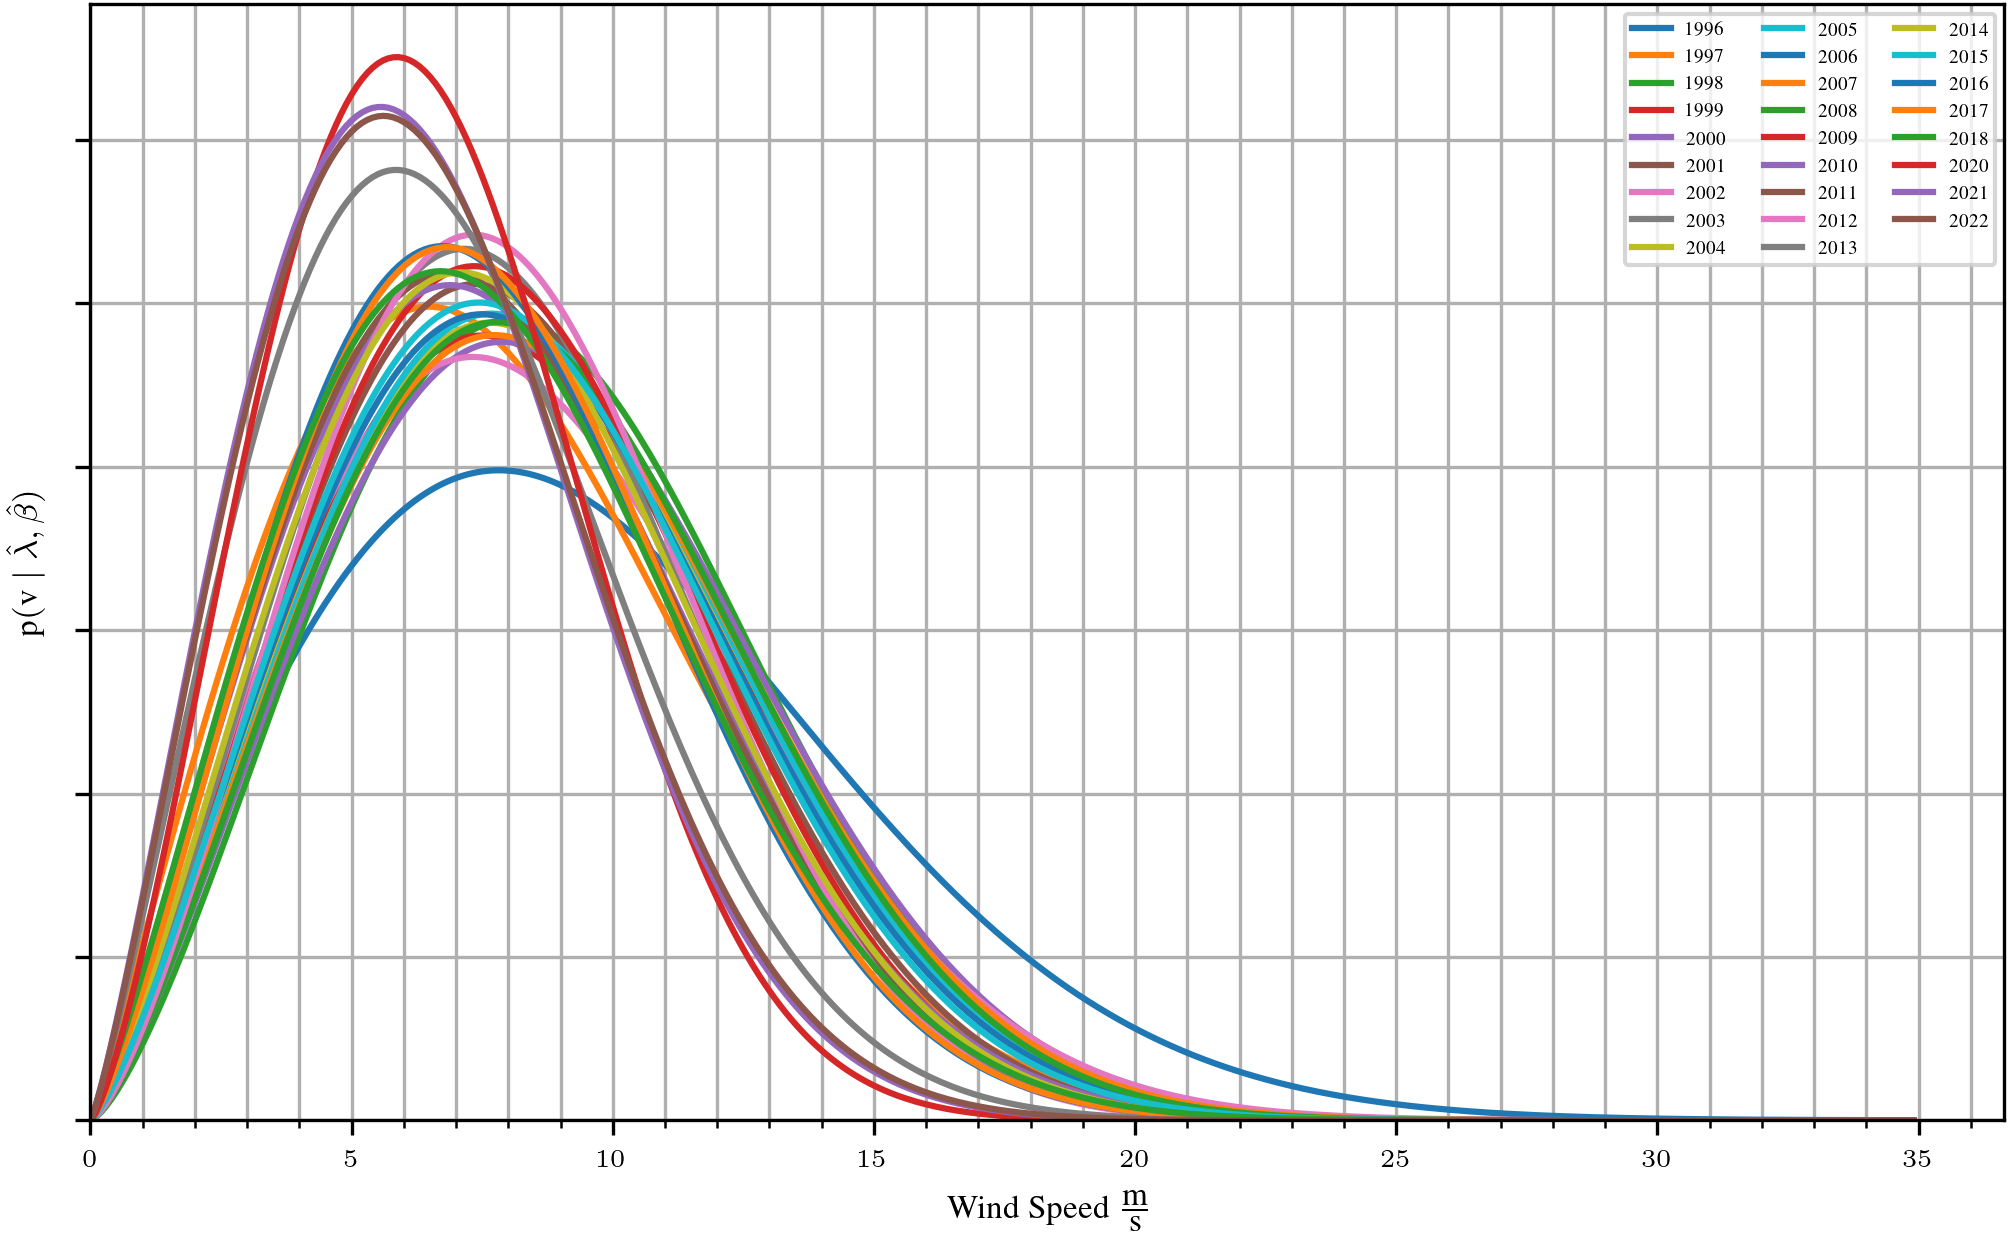

In [17]:
fig, ax = plt.subplots(1, 1)

X = np.arange(0, 35, 0.1)
Y = []
for year, year_df in wind_year_dists.groupby("year"):
    w = year_df["weibull"].values[0]
    y = w.pdf(X)
    Y.append(y)
    plt.plot(X, y, label=year)
wind_year_dists["prob"] = Y

ax.grid(which="both")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.set_yticklabels([])
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(ncols=(2022 - 1996) / 8, fontsize="xx-small")
ax.set_xlabel(r"Wind Speed $\frac{\textrm{m}}{\textrm{s}}$")
ax.set_ylabel(r"$\textrm{p}(\textrm{v} \mid \hat{\lambda}, \hat{\beta})$")

(0.0, 30.0)

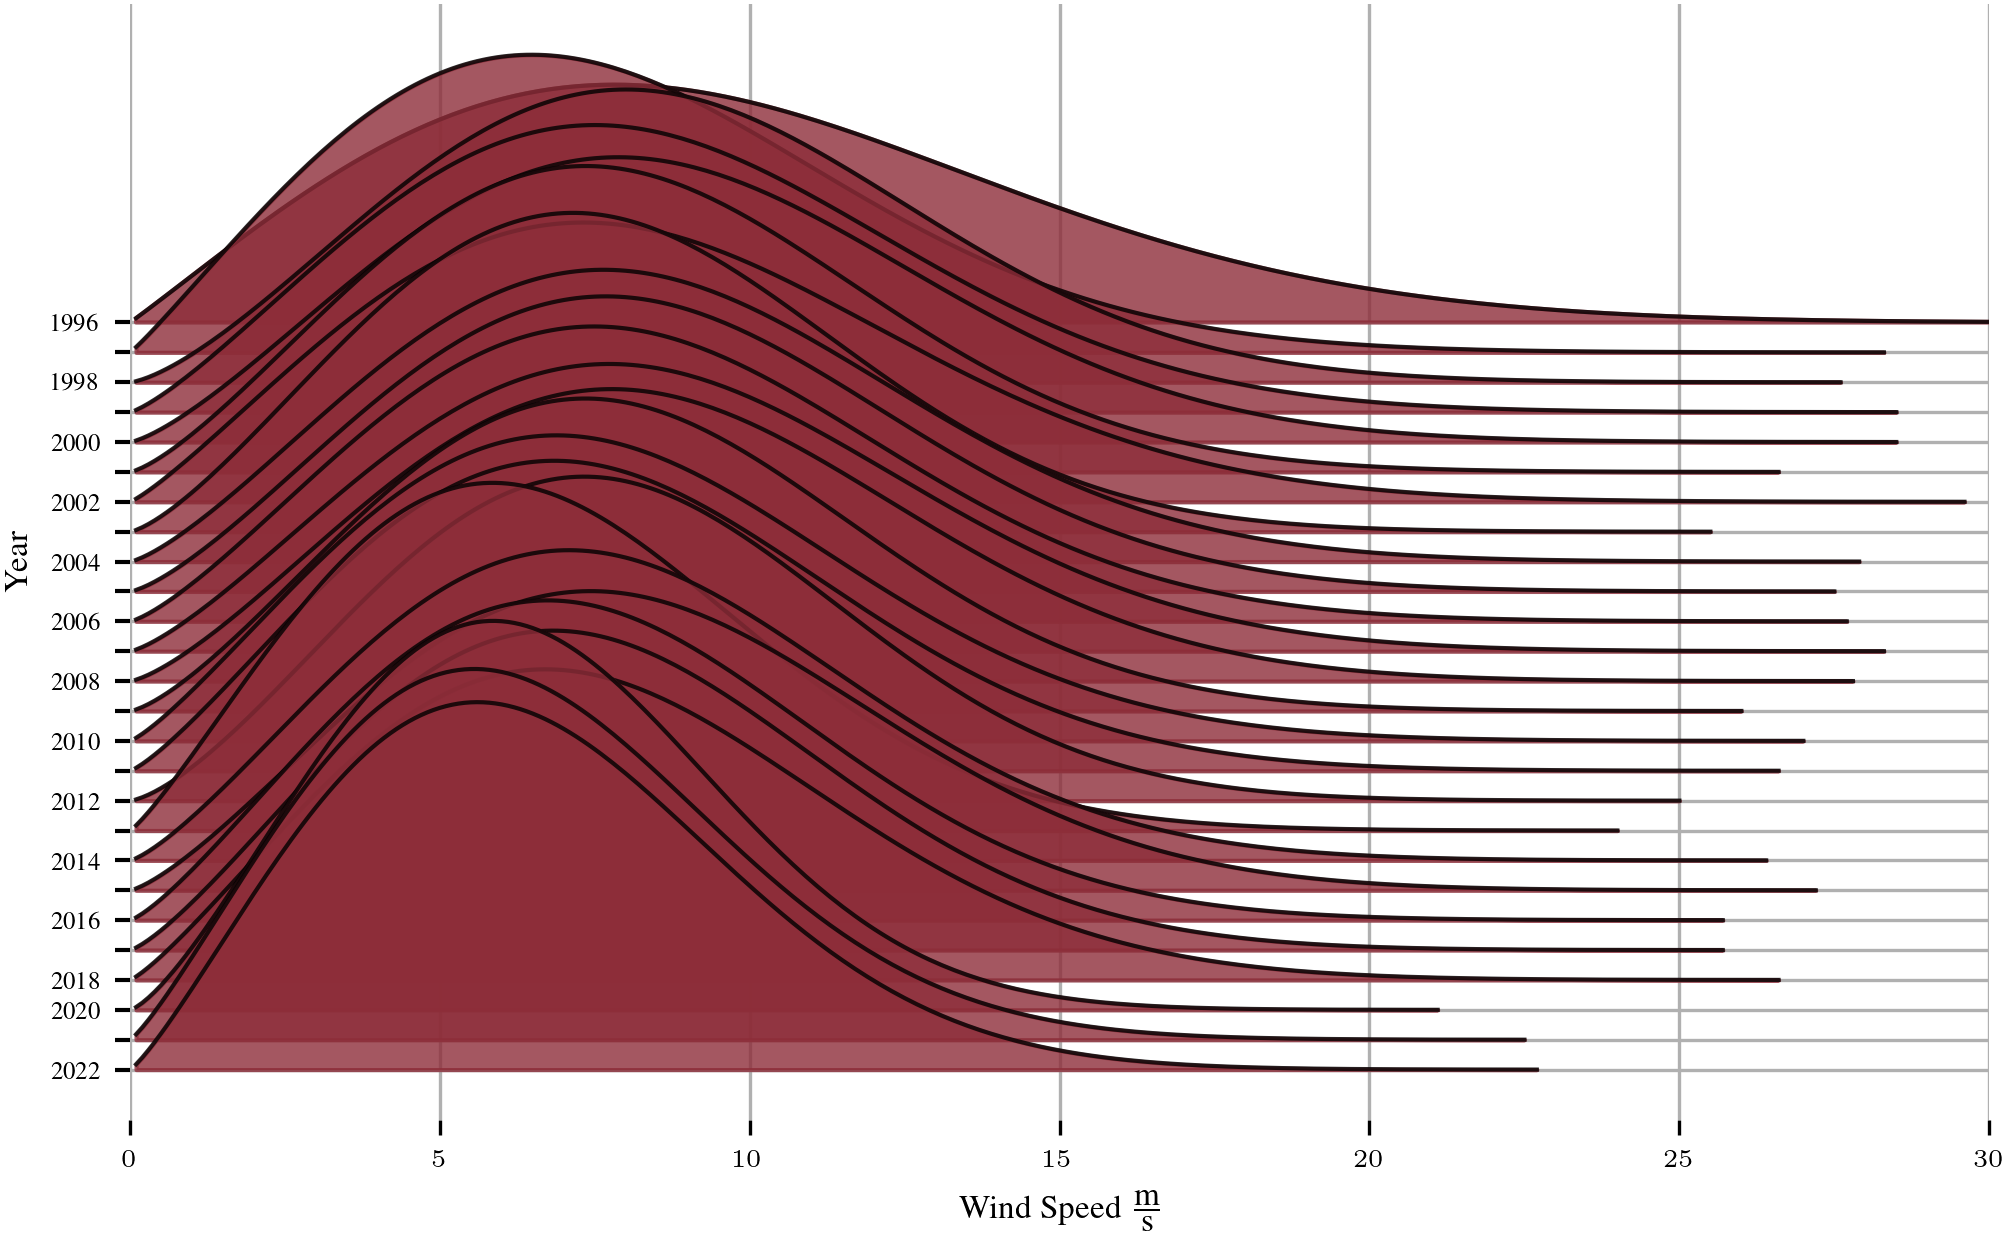

In [18]:
fig, ax = plt.subplots()
labels = [y if y % 2 == 0 else None for y in list(wind_year_dists.year)]
ridgeline_plot(np.tile(X, (len(Y), 1)), np.array(Y[::-1]), ax, labels[::-1], overlap=0.99, range_threshold=1e-5, alpha=0.8, fill_color=tp.constants.color.rgb.tue_red, fill=True)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.yaxis.set_tick_params(width=1)
ax.set_xlabel(r"Wind Speed $\frac{\textrm{m}}{\textrm{s}}$")
ax.set_ylabel("Year")
ax.set_xlim(0, 30)

In [19]:
wind_month_pdfs = []
Y = []
for (year, month), year_month_df in wind_df.groupby(["year", "month"]):
    y = year_month_df["FF_10_wind"].dropna().copy()
    weibull = Weibull.estimate(y)
    Y.append(weibull.pdf(X))
    wind_month_pdfs.append([year, month, weibull, y, weibull.pdf(X)])
wind_month_pdfs = pd.DataFrame(wind_month_pdfs, columns=["year", "month", "weibull", "X", "prob"])
wind_month_pdfs
        

year  month                                            weibull  \
0    1996     12   Weibull distr for lambda=10.901997394939055, ...   
1    1997      1   Weibull distr for lambda=7.957978441723365, b...   
2    1997      2   Weibull distr for lambda=12.056819405208966, ...   
3    1997      3   Weibull distr for lambda=8.983493404318594, b...   
4    1997      4   Weibull distr for lambda=9.45360763877412, be...   
..    ...    ...                                                ...   
296  2022      8   Weibull distr for lambda=5.286573366235021, b...   
297  2022      9   Weibull distr for lambda=7.501257710648738, b...   
298  2022     10   Weibull distr for lambda=7.651447270742967, b...   
299  2022     11   Weibull distr for lambda=9.775116693614796, b...   
300  2022     12   Weibull distr for lambda=8.137357974083713, b...   

                                                     X  \
0    0       15.8
1       16.2
2       16.6
3      ...   
1    1559    7.9
1560    8.7
1561    8.8
1562    8....   
2    5428    3.2
5429    3.1
5430    3.0
5431    2....   
3    8922     8.2
8923     8.5
8924     8.3
8925   ...   
4    12772    7.2
12773    6.8
12774    6.8
12775  ...   
..                                                 ...   
296  132715    6.2
132716    6.4
132717    6.1
1327...   
297  137179     7.7
137180     7.2
137181     7.2
1...   
298  141499    12.2
141500    12.8
141501    11.7
1...   
299  145963    10.3
145964    10.2
145965     9.7
1...   
300  150283     5.6
150284     5.7
150285     5.6
1...   

                                                  prob  
0    [0.0, 0.001456030514843955, 0.0029818205386610...  
1    [0.0, 0.0019357676475951619, 0.004222819735420...  
2    [0.0, 9.125924520525411e-06, 4.024622514359949...  
3    [0.0, 0.0004892605920791548, 0.001292262755260...  
4    [0.0, 0.00036536376749693905, 0.00099284881526...  
..                                                 ...  
296  [0.0, 0.0006539187143034846, 0.002089945823990...  
297  [0.0, 0.004522467486209736, 0.0086509893111239...  
298  [0.0, 0.00011190128352126835, 0.00040946783646...  
299  [0.0, 0.00017454005689609853, 0.00052883879614...  
300  [0.0, 3.165321794396556e-05, 0.000139383008839...  

[301 rows x 5 columns]

(0.0, 30.0)

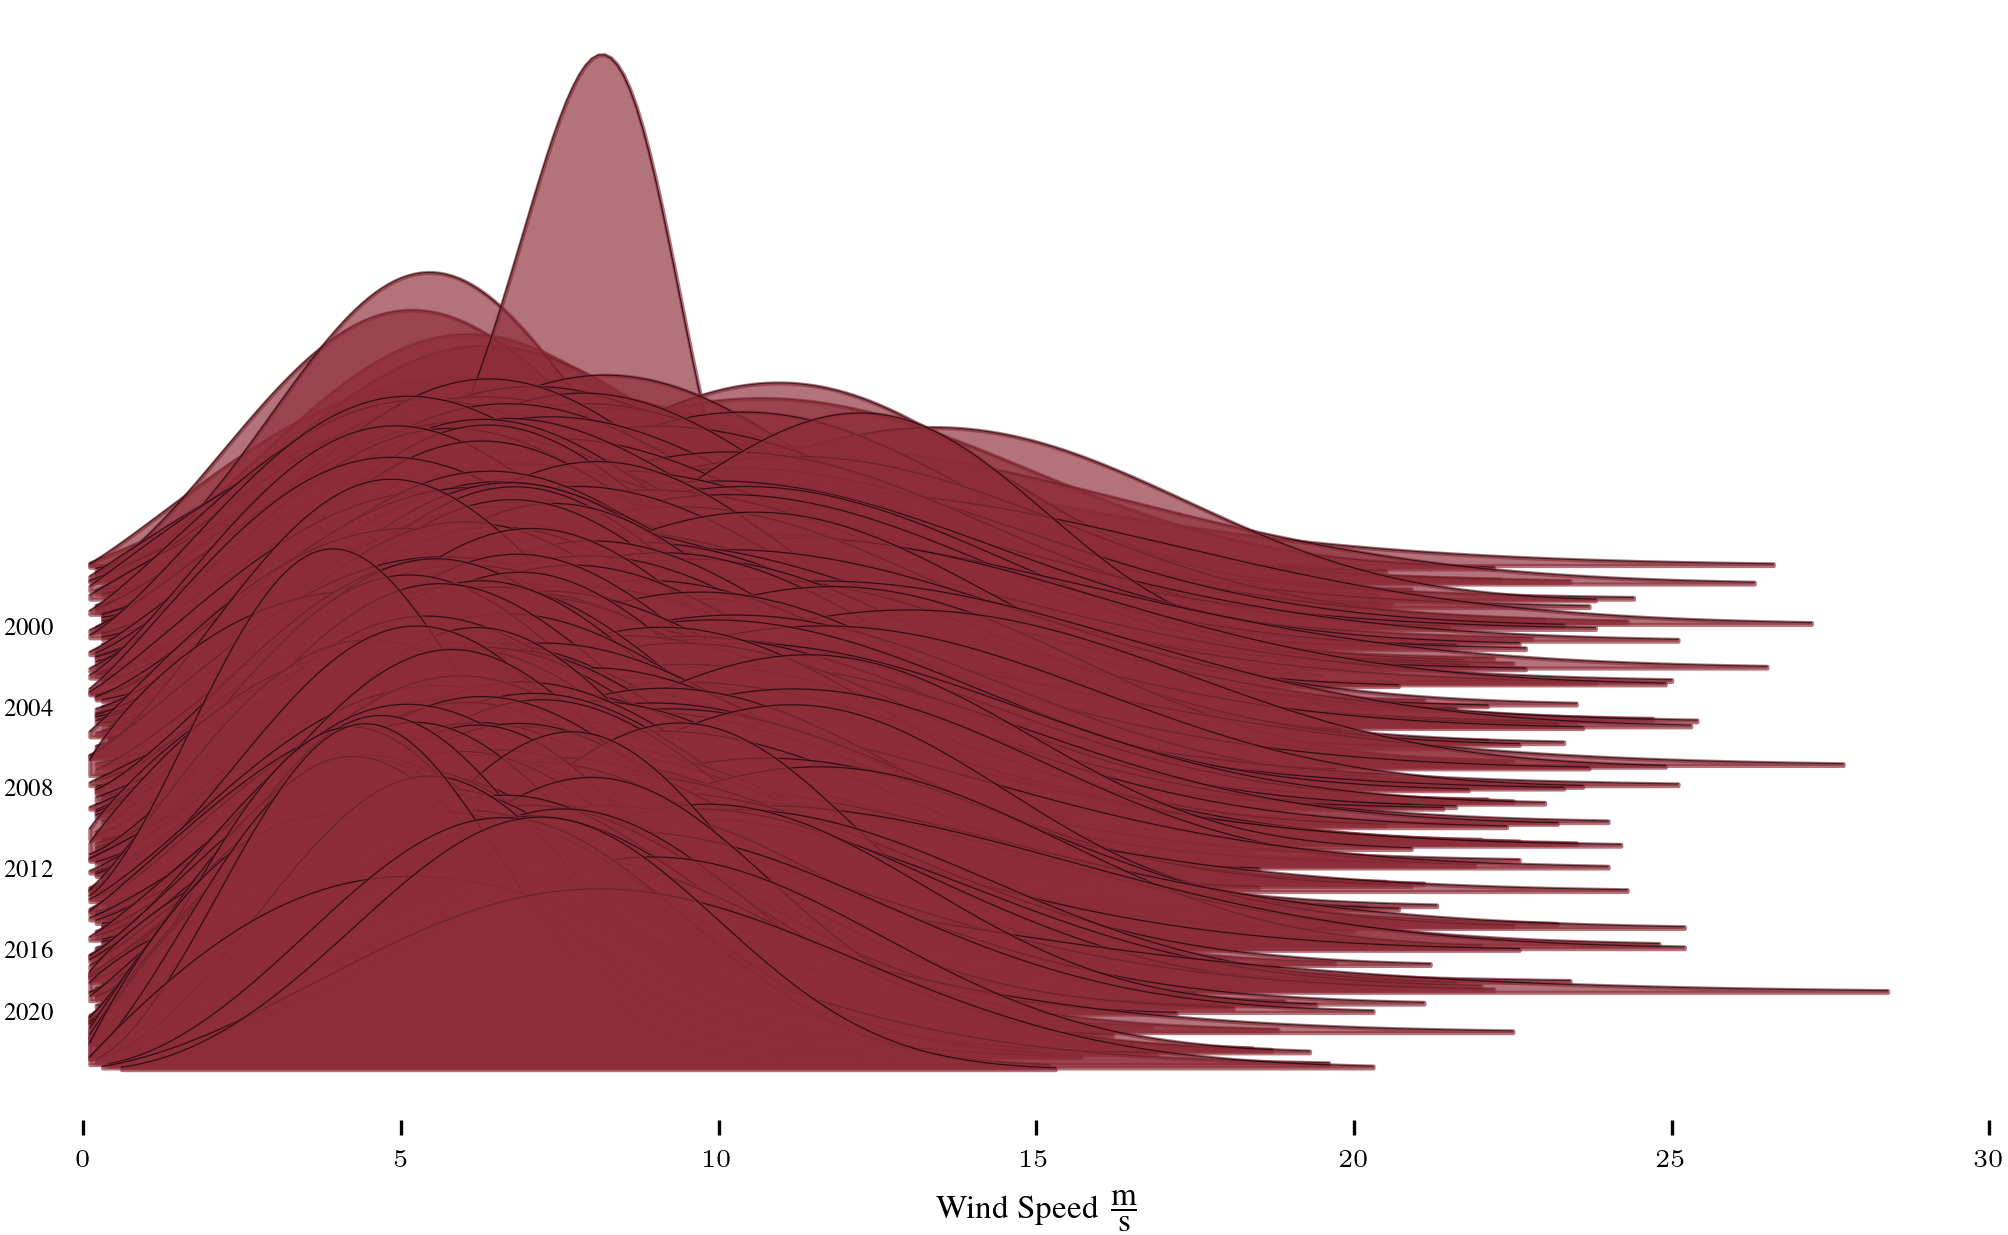

In [20]:
full_fig()
fig, ax = plt.subplots()
labels = [yr if yr % 4 == 0 and mth == 1 else None for yr, mth in zip(list(wind_month_pdfs.year), list(wind_month_pdfs.month))]
ridgeline_plot(np.tile(X, (len(Y), 1)), np.array(Y[::-1]), ax, labels[::-1], overlap=0.999, range_threshold=1e-3, alpha=2/3, linewidth=0.3, fill_color=tp.constants.color.rgb.tue_red, fill=True)
ax.yaxis.grid(True, linewidth=0)
ax.yaxis.set_tick_params(width=0)
ax.set_xlabel(r"Wind Speed $\frac{\textrm{m}}{\textrm{s}}$")
ax.set_xlim(0, 30)

In [21]:
# https://en.wikipedia.org/wiki/Density_of_air#Dry_air
air_rho = 1.2250
# 120 meter diameter of wind turbine
sweep_area = math.pi * (70 / 2) ** 2

def expected_density(p: Weibull, A=sweep_area, rho=air_rho):
    # E[1/2 * rho * v^3] = 1/2 * rho * E[v^3] = 1/2 * rho * lambda^3 * G(1 + 3 / beta)
    # 1/2 * rho * v^3: 1/2 * kg/m^3 * m^3 / s^3 = W/m^2
    return 1/2 * rho * p.n_raw_moment(n=3)

def third_raw_moment(X, p: Weibull, rho=air_rho):
    return 1/2 * rho * np.atleast_1d(X) ** 3 * p.pdf(np.atleast_1d(X))

# test_year = wind_year_dists[wind_year_dists.year == 2010]
# X = test_year.data.values.flatten()[0]
# dist = test_year.weibull.values[0]
# x = np.linspace(0, 25, 100)
# integrant = lambda y: third_raw_moment(y, dist)
# result = scipy.integrate.quad(integrant, 5, 25)
# result
# # third_raw_moment(X, test_year.weibull.values[0])

/var/folders/zk/8tsl64_x29qcn5z6qjdgwh5h0000gn/T/ipykernel_10957/3691831701.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


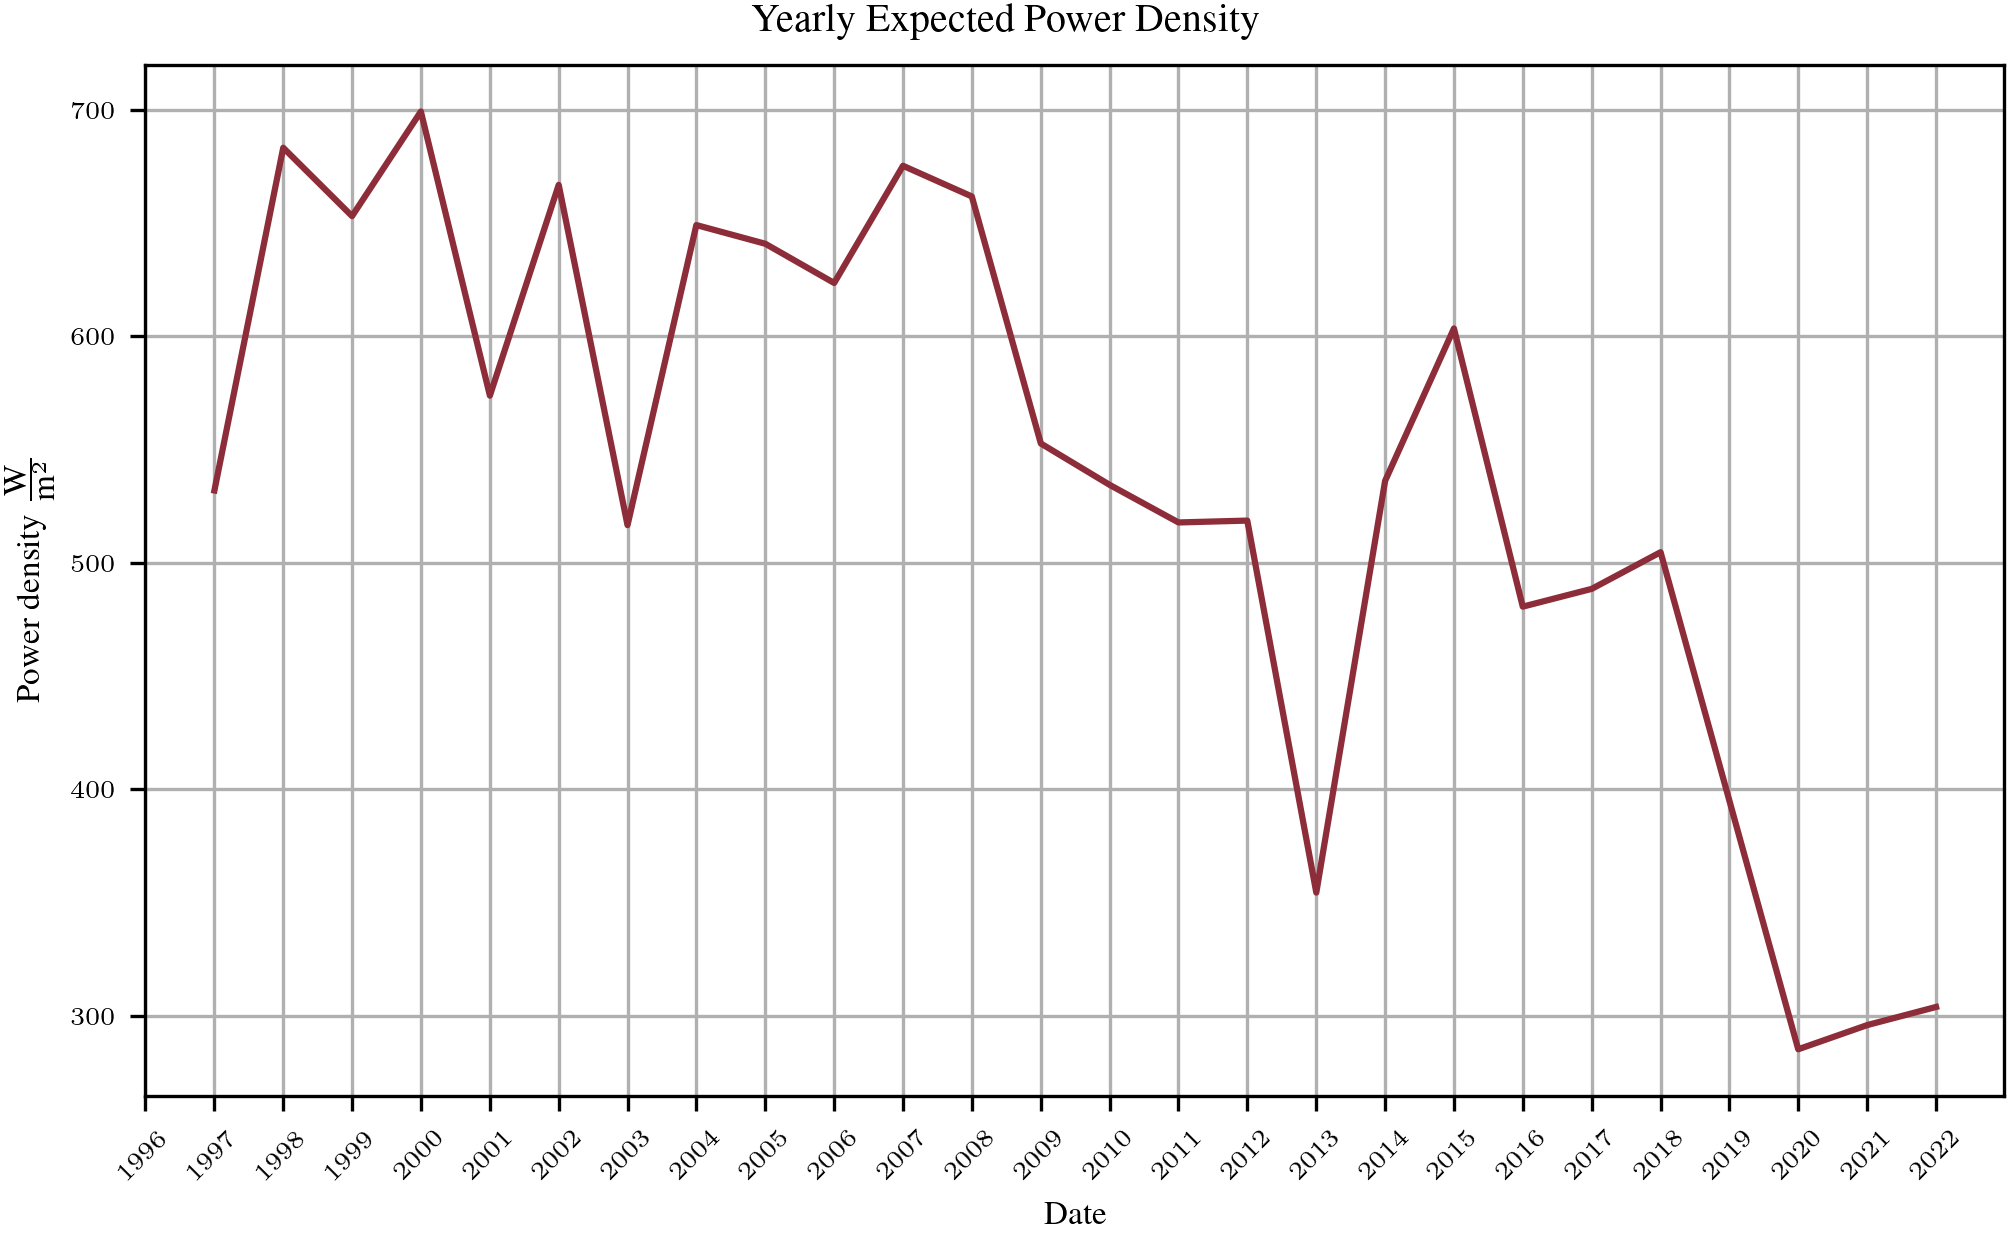

In [22]:
# plot expected values for each year
fig, ax = plt.subplots()
vals = []
for year, year_df in wind_year_dists.groupby("year"):
    if year < 1997: continue
    dist = year_df.weibull.values[0]
    integrant = lambda x: third_raw_moment(x, dist)
    result, _ = scipy.integrate.quad(integrant, 3, 22)
    vals.append((year, result))
years = list(map(lambda t: dt.datetime(t[0], 1, 1), vals))
e = list(map(lambda t: t[1], vals))
ax.plot(years, e, color=tpc.rgb.tue_red)
ax.xaxis.set_major_locator(mdt.YearLocator())
ax.xaxis.set_major_formatter(mdt.DateFormatter("%Y"))
ax.tick_params(axis='x', which="major", rotation=45)
ax.set_xlabel("Date")
ax.set_xlim((dt.datetime(1996, 1, 1), dt.datetime(2022, 12, 30)))
ax.set_ylabel(r"Power density $\frac{\textrm{W}}{\textrm{m}^2}$")
ax.grid()
fig.suptitle("Yearly Expected Power Density")
fig.show()

Text(0.5, 0.98, 'Monthly Expected Power Density')

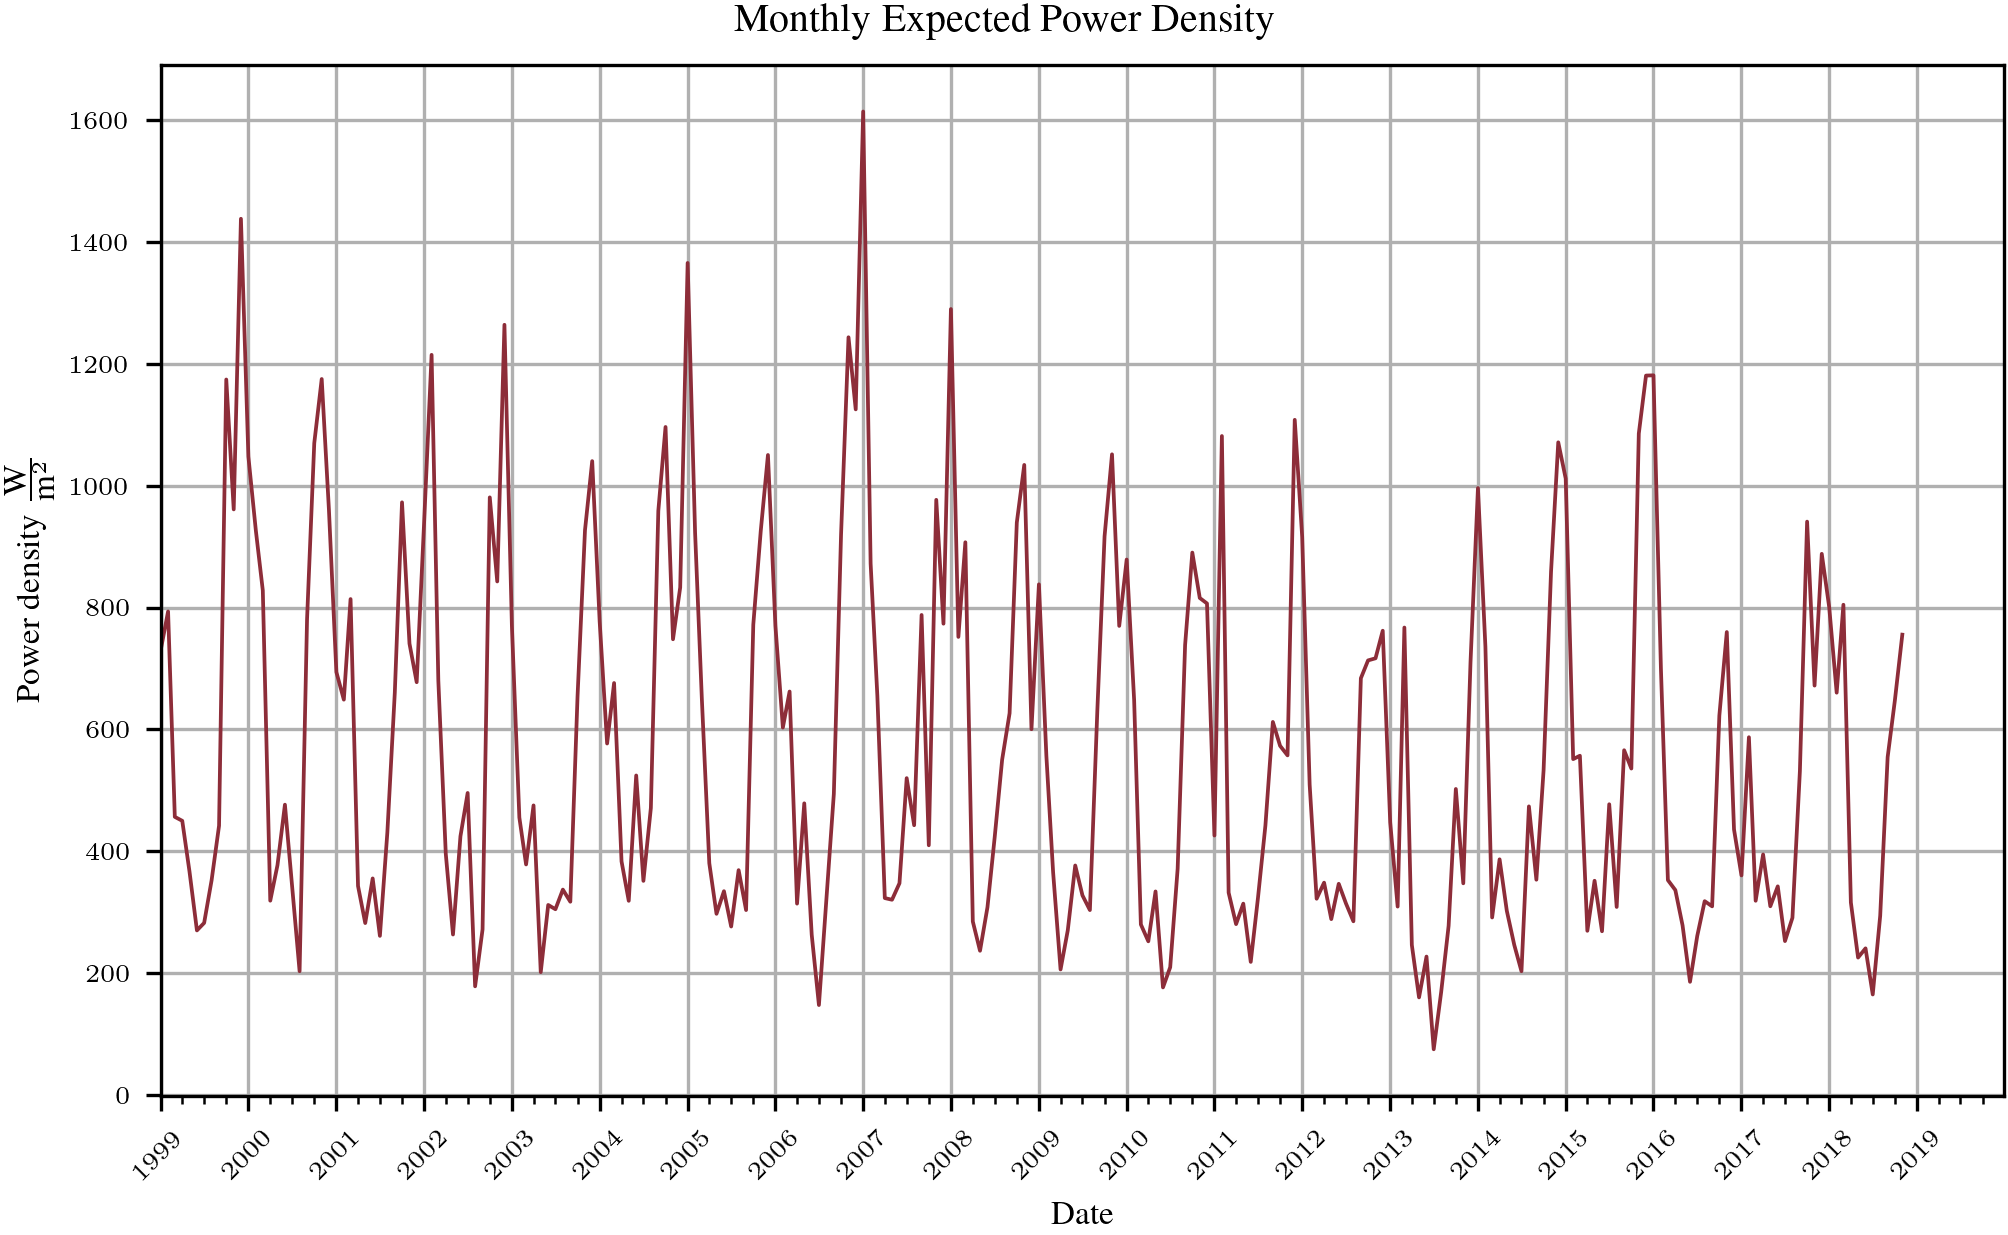

In [23]:
start_y = 1999
start_dt = dt.datetime(start_y, 1, 1)
end_y = 2018 # inclusive
step_size = 1
extrapol_days = 365 * 10

# plot expected values for each month
fig, ax = plt.subplots(1, 1)
vals = []
for (year, month), year_month_df in wind_month_pdfs.groupby(["year", "month"]):
    if year < start_y or year > end_y: continue
    dist = year_month_df.weibull.values[0]
    integrant = lambda x: third_raw_moment(x, dist)
    result, _ = scipy.integrate.quad(integrant, 3, 22)
    vals.append((year, month, result))
    # vals.append((year, month, year_month_df.pdf.values[0].mean))
months = list(map(lambda t: dt.datetime(t[0], t[1], 1), vals))
e = list(map(lambda t: t[2], vals))
ax.plot(months, e, color=tpc.rgb.tue_red, linewidth=0.9)
ax.xaxis.set_major_locator(mdt.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdt.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdt.MonthLocator(interval=3))
# ax.xaxis.set_minor_formatter(mdt.DateFormatter("%B"))
ax.tick_params(axis='x', which='minor', rotation=90)
ax.tick_params(axis='x', which="major", rotation=45)
ax.set_xlabel("Date")
ax.set_xlim((dt.datetime(start_y, 1, 1), dt.datetime(end_y + 1, 12, 31)))
ax.set_ylabel(r"Power density $\frac{\textrm{W}}{\textrm{m}^2}$")
ax.grid()
fig.suptitle("Monthly Expected Power Density")

In [464]:
X = np.array(list(map(lambda d: (d - start_dt).days, months))).reshape(-1, 1)
Y = np.array(e)
r = range(0, 365 * (end_y - start_y) + extrapol_days, step_size)
x = np.array(r).reshape(-1, 1)

# TODO Wiener-Kernel?, multiplicative
k1 = 1e-5 * GPK.DotProduct() + GPK.ExpSineSquared(length_scale=1, periodicity=180) + GPK.ExpSineSquared(length_scale=1, periodicity=365) + 0.1 * GPK.RBF(length_scale=30) # * GPK.Matern(length_scale=180, nu=5/2)

# ---
# 0.038**2 * RBF(length_scale=5.62) + 
# 1.14**2 * RBF(length_scale=1.72e+04) * ExpSineSquared(length_scale=1.68, periodicity=365) +
# 0.583**2 * RationalQuadratic(alpha=0.61, length_scale=7.76) +
# 0.0818**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.00635)
long_term_trend_kernel = 1e-5**2 * GPK.DotProduct(Y.max() - Y.min()) ** 2
yearly_trend_kernel = 250**2 * GPK.ExpSineSquared(length_scale=1.15, periodicity=365)
seasonal_kernel = 50**2 * GPK.ExpSineSquared(length_scale=1.5, periodicity=180) * (5e-3**2 * GPK.RBF(length_scale=1.5))
irregularities_kernel = 1.5e-1 * GPK.RBF(length_scale=30)
k2 = yearly_trend_kernel + long_term_trend_kernel + seasonal_kernel + irregularities_kernel
# ---

gp = GP(kernel=k2, alpha=0.25, normalize_y=True, random_state=1, optimizer=None)

Text(0.5, 1.0, 'Prior Samples')

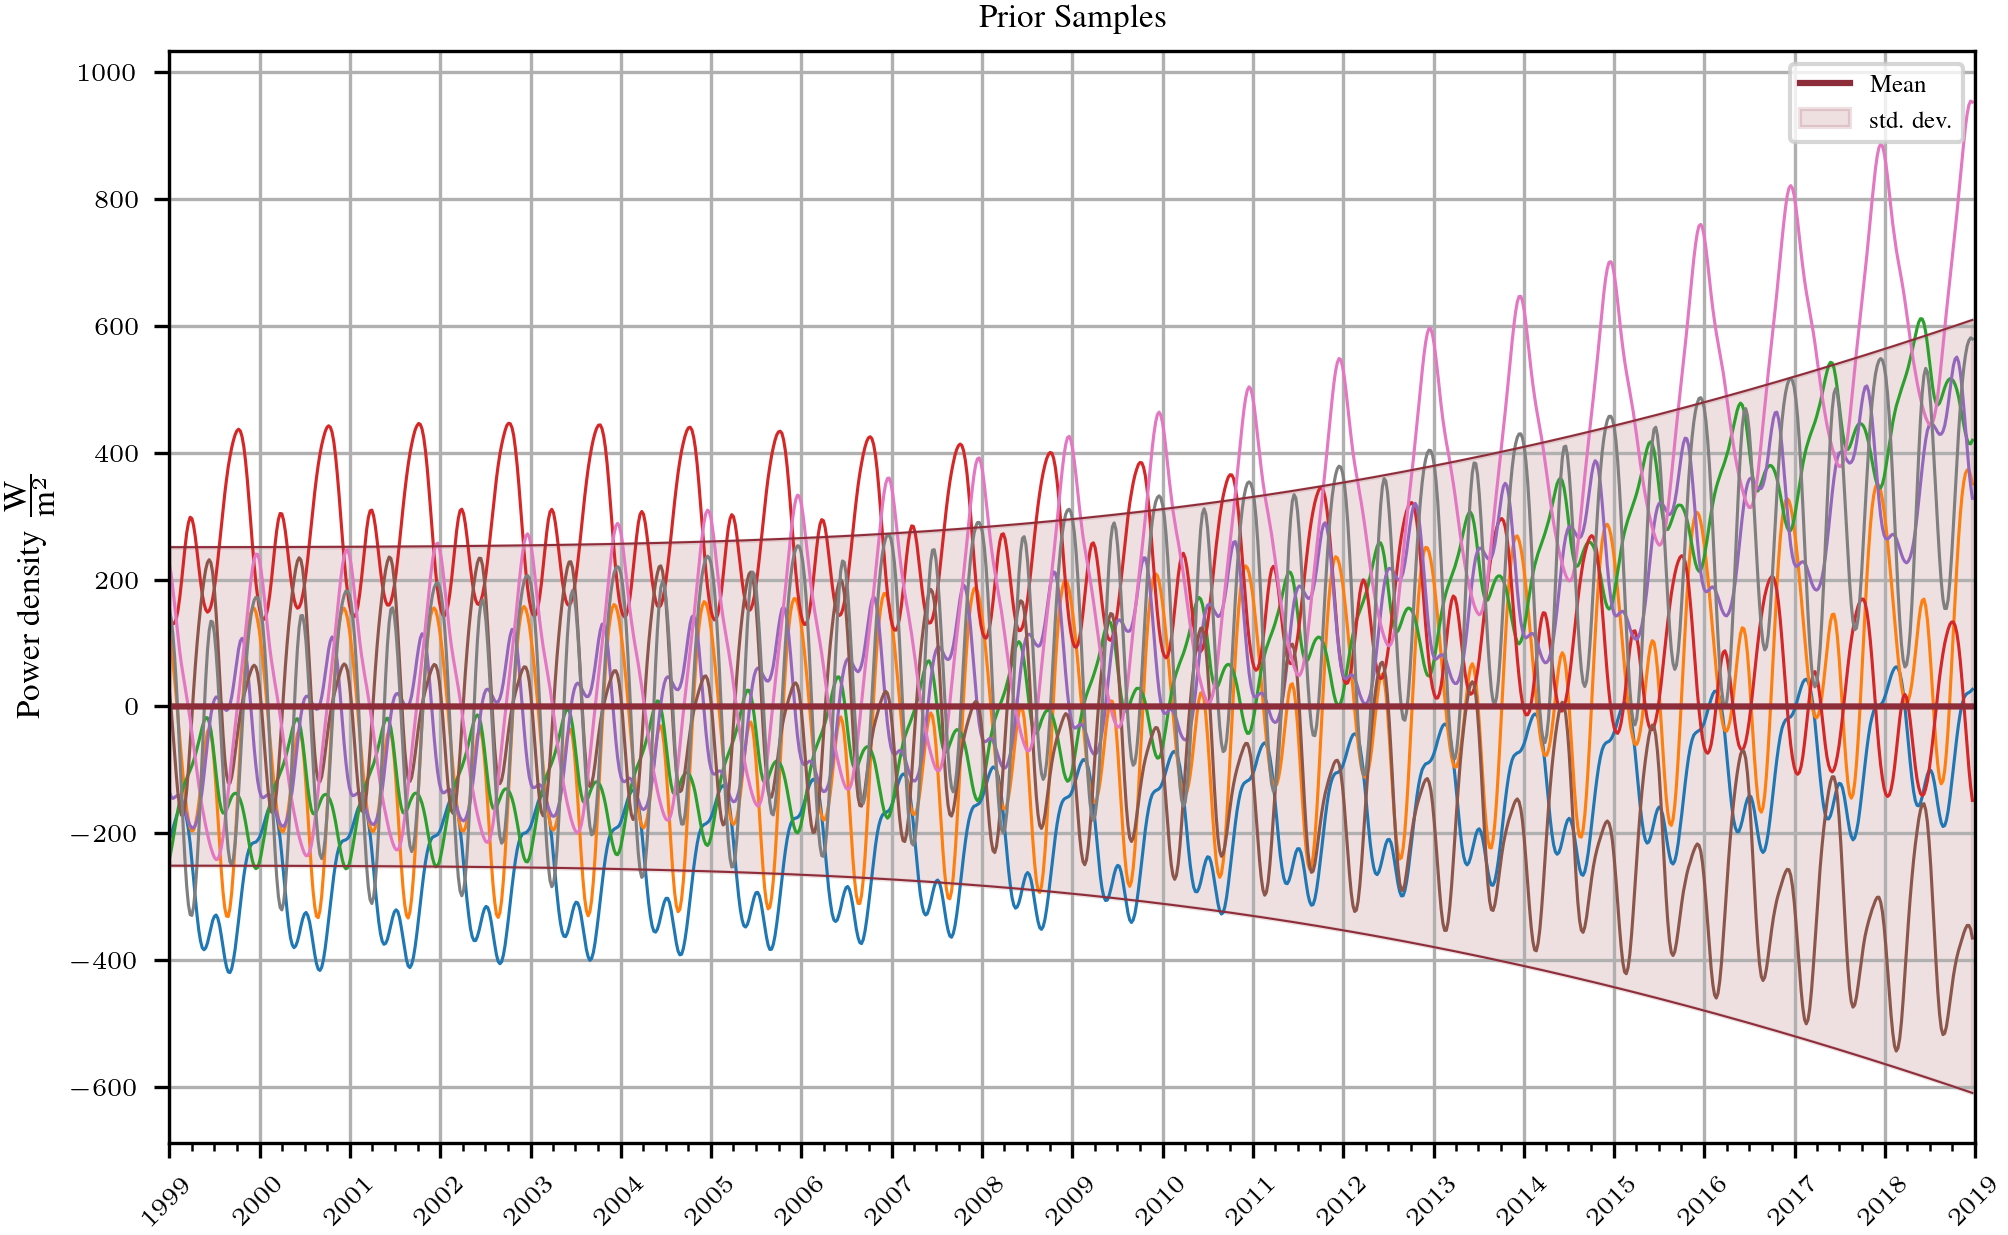

In [465]:
full_fig()
fig, ax = plt.subplots()

sample_steps = 7

x_sample = np.array(range(0, 365 * (end_y + 1 - start_y), sample_steps)).reshape(-1, 1)
samples = gp.sample_y(x_sample, n_samples=8, random_state=42)
pred_mean, pred_std = gp.predict(x_sample, return_std=True)
x_sample_dt = days_to_date(start_dt, x_sample)

ax.plot(x_sample_dt, samples, linewidth=0.75)
ax.plot(x_sample_dt, pred_mean, label="Mean", color=tpc.rgb.tue_red)
ax.plot(x_sample_dt, pred_mean + pred_std, color=tpc.rgb.tue_red, linewidth=0.5) 
ax.plot(x_sample_dt, pred_mean - pred_std, color=tpc.rgb.tue_red, linewidth=0.5)
ax.fill_between(x_sample_dt, pred_mean + pred_std, pred_mean - pred_std, alpha=0.15, color=tpc.rgb.tue_red, label="std. dev.")
ax.legend(ncols=1)
ax.set_xlim(dt.datetime(start_y, 1, 1), dt.datetime(end_y + 1, 1, 1))
ax.xaxis.set_minor_locator(mdt.MonthLocator(interval=3))
ax.xaxis.set_major_locator(mdt.YearLocator(base=1))
ax.tick_params(axis='x', which="major", rotation=45)
ax.grid()
ax.set_ylabel(r"Power density $\frac{\textrm{W}}{\textrm{m}^2}$")
ax.set_title("Prior Samples")

250**2 * ExpSineSquared(length_scale=1.15, periodicity=365) + 1e-05**2 * DotProduct(sigma_0=1.54e+03) ** 2 + 50**2 * ExpSineSquared(length_scale=1.5, periodicity=180) * 0.005**2 * RBF(length_scale=1.5) + 0.387**2 * RBF(length_scale=30)


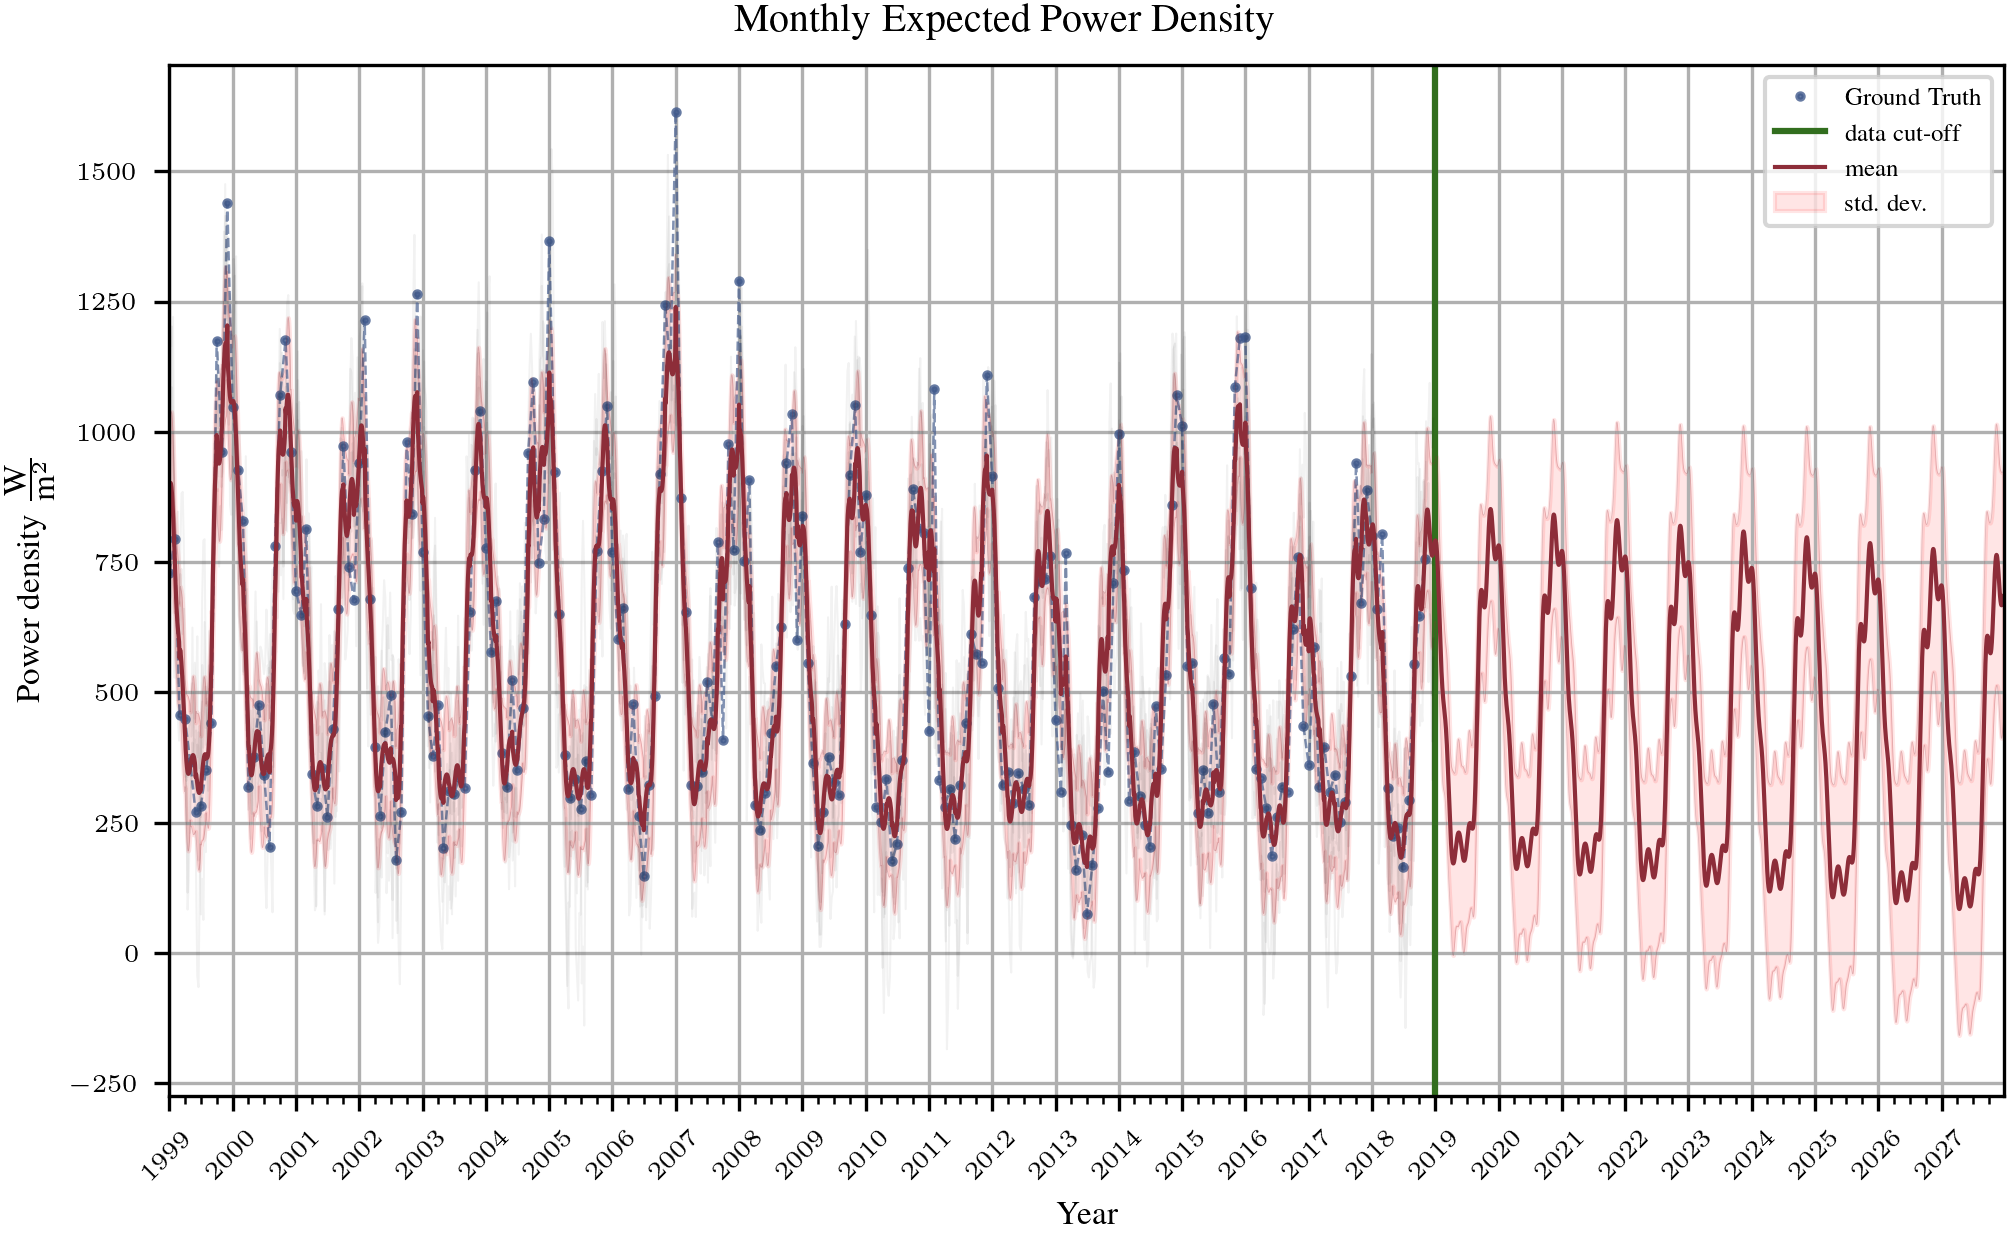

In [495]:
gp.fit(X, Y)
pred_mean, std = gp.predict(x, return_std=True)
samples = gp.sample_y(x_sample, n_samples=5)
x_dt = days_to_date(start_dt, x)

fig, ax = plt.subplots()

X_dt = days_to_date(start_dt, X)
ax.plot(X_dt, Y, "--", color=tpc.rgb.tue_darkblue, linewidth=0.6, alpha=2/3)
ax.plot(X_dt, Y, ".", label="Ground Truth", markersize=3, color=tpc.rgb.tue_darkblue, alpha=0.8)

ax.axvline(dt.datetime(end_y + 1, 1, 1), color=tpc.rgb.tue_darkgreen, linewidth=1.5, label="data cut-off")

ax.plot(x_sample_dt, samples, alpha=0.05, color="black", linewidth=0.5)
ax.plot(x_dt, pred_mean, "-", linewidth=1, label="mean", color=tpc.rgb.tue_red)
ax.plot(x_dt, pred_mean + std, "-", alpha=0.25, color=tpc.rgb.tue_red, linewidth=0.2)
ax.plot(x_dt, pred_mean - std, "-", alpha=0.25, color=tpc.rgb.tue_red, linewidth=0.2)
ax.fill_between(x_dt, pred_mean + std, pred_mean - std, color="red", alpha=0.1, label="std. dev.")


ax.set_xlim(dt.datetime(start_y, 1, 1), dt.datetime(end_y, 1, 1) + dt.timedelta(extrapol_days))
# ax.set_ylim(0)
ax.set_ylabel(r"Power density $\frac{\textrm{W}}{\textrm{m}^2}$")
ax.set_xlabel("Year")
ax.xaxis.set_minor_locator(mdt.MonthLocator(interval=3))
ax.xaxis.set_major_locator(mdt.YearLocator(base=1))
ax.legend(ncols=1)
ax.tick_params(axis='x', which="major", rotation=45)
ax.grid()
fig.suptitle("Monthly Expected Power Density")
plt.savefig(os.path.join(FIGURE_FOLDER, "gp_pred.pdf"))
print(gp.kernel_)